In [1]:
import sys

sys.path.append("ares_transverse_tuning")

In [2]:
import time
from datetime import datetime
from pathlib import Path

import gymnasium as gym
import langchain
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
from dotenv import load_dotenv
from gymnasium.wrappers import TimeLimit
from icecream import ic
from langchain.callbacks import FileCallbackHandler, wandb_tracing_enabled
from langchain.chains import LLMChain
from langchain.chat_models import ChatOllama
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from loguru import logger
from openai import RateLimitError
from src.environments.ea import TransverseTuning
from src.eval import Episode
from src.trial import load_trials
from src.wrappers import RecordEpisode, TQDMWrapper

from pacuna import PACuna

In [3]:
load_dotenv()

plt.style.use(["science", "nature", "no-latex"])

langchain.debug = True

In [4]:
# chat_model = ChatOpenAI(model="gpt-3.5-turbo-0125")
# chat_model = ChatOpenAI(model="gpt-4")
# chat_model = ChatOpenAI(model="gpt-4-32k")
chat_model = ChatOpenAI(model="gpt-4-0125-preview")
# chat_model = ChatOllama(model="mistral:v0.2", base_url="http://max-wng053:11434")
# chat_model = ChatOllama(model="zephyr", base_url="http://max-wng052:11434")
# chat_model = ChatOllama(model="mixtral:8x7b", base_url="http://max-wng060:11434")
# chat_model = ChatOllama(model="gemma:2b", base_url="http://max-wng060:11434")
# chat_model = ChatOllama(model="gemma:7b", base_url="http://max-wng053:11434")
# chat_model = ChatOllama(
#     model="starling-lm:7b-beta", base_url="http://max-cssbg012:11434"
# )
# chat_model = ChatOllama(model="vicuna:7b-16k", base_url="http://max-cssbg012:11434")
# chat_model = ChatOllama(model="vicuna:33b", base_url="http://max-wng054:11434")
# chat_model = ChatOllama(model="llava:34b", base_url="http://max-wng054:11434")
# chat_model = ChatOllama(model="orca2:7b", base_url="http://max-cssbg012:11434")
# chat_model = ChatOllama(model="orca2:13b", base_url="http://max-cssbg012:11434")
# chat_model = ChatOllama(model="llama2:7b", base_url="http://max-wng053:11434")
# chat_model = ChatOllama(model="llama2:13b", base_url="http://max-wng053:11434")
# chat_model = ChatOllama(model="llama2:70b", base_url="http://max-wng053:11434")
# chat_model = ChatOllama(model="falcon:180b-chat", base_url="http://max-wng054:11434")
# chat_model = ChatOllama(model="neural-chat:7b")
# chat_model = ChatOllama(model="mistral-openorca:7b", base_url="http://max-wng052:11434")
# chat_model = ChatOllama(model="phi:chat")
# chat_model = ChatOllama(model="megadolphin:120b", base_url="http://max-wng053:11434")
# chat_model = ChatOllama(model="yi:34b-chat", base_url="http://max-wng054:11434") x
# chat_model = PACuna()

In [5]:
# chat_model.invoke("Hello")

In [6]:
TRIAL_INDEX = 38
trials = load_trials(Path("ares_transverse_tuning/data/trials.yaml"))
trial = trials[TRIAL_INDEX]
trial

Trial(target_beam=array([-0.00061349,  0.00026242,  0.00102625,  0.0003465 ]), incoming_beam=array([ 1.31279831e+08, -7.41156109e-04, -5.82922221e-05,  1.30710745e-04,
       -7.66231824e-06,  3.57008132e-04,  4.35580478e-05,  2.26216856e-04,
        1.96636520e-05,  1.79446160e-05,  2.96076818e-04]), misalignments=array([ 8.31616237e-05,  1.81952708e-04, -3.13049472e-04,  2.17823154e-04,
       -8.04967923e-05,  2.33286971e-04,  1.15469446e-04, -1.41215460e-04]), initial_magnets=array([ 1.06084118e+01, -1.92286568e+01,  2.02686829e-03,  8.72032261e+00,
       -5.51228318e-03]))

In [7]:
model_name = (
    chat_model.model_name if hasattr(chat_model, "model_name") else chat_model.model
).replace(":", "-")
now = datetime.now()

log_dir = (
    Path("data")
    / "paper"
    / "cot"
    / model_name
    / f"trial-{TRIAL_INDEX}_{now.strftime('%Y-%m-%d_%H-%M-%S')}"
)
langchain_log_file = log_dir / "langchain.log"
logger.add(langchain_log_file, colorize=True, enqueue=True)
handler = FileCallbackHandler(langchain_log_file)

In [8]:
log_dir

PosixPath('data/paper/cot/gpt-4-0125-preview/trial-38_2024-04-25_09-55-51')

In [9]:
env = TransverseTuning(
    action_mode="direct",
    magnet_init_mode=trial.initial_magnets,
    target_beam_mode=trial.target_beam,
    backend="cheetah",
    backend_args={
        "incoming_mode": trial.incoming_beam,
        "misalignment_mode": trial.misalignments,
        "generate_screen_images": False,
    },
)
# env = TimeLimit(env, max_episode_steps=18)
# env = RecordEpisode(env, Path("data/recorded_episodes"))
# env = TQDMWrapper(env)
env

In [10]:
# sample_template = """Magnet settings:
# ```json
# {{
# 	"Q1": {q1:.2f},  // m^-2
# 	"Q2": {q2:.2f},  // m^-2
# 	"CV": {cv:.2f},  // mrad
# 	"Q3": {q3:.2f},  // m^-2
# 	"CH": {ch:.2f}  // mrad
# }}
# ```
# Beam parameters:
# ```json
# {{
# 	"horizontal position": {mu_x:.2f},  // mm
# 	"horizontal size": {sigma_x:.2f},  // mm
# 	"vertical position": {mu_y:.2f},  // mm
# 	"vertical size": {sigma_y:.2f}  // mm
# }}
# ```
# """

In [11]:
sample_template = """Magnet settings:
```json
{{
	"Q1": {q1:.2f},
	"Q2": {q2:.2f},
	"CV": {cv:.2f},
	"Q3": {q3:.2f},
	"CH": {ch:.2f}
}}
```
Beam parameters:
```json
{{
	"mu_x": {mu_x:.2f},
	"sigma_x": {sigma_x:.2f},
	"mu_y": {mu_y:.2f},
	"sigma_y": {sigma_y:.2f}
}}
```
"""
target_template = """Target beam parameters:
```json
{{
	"mu_x": {mu_x:.2f},
	"sigma_x": {sigma_x:.2f},
	"mu_y": {mu_y:.2f},
	"sigma_y": {sigma_y:.2f}
}}
```
"""

In [12]:
message_template = """Now you will help me optimise the horizontal and vertical position and size of an electron beam on a diagnostic screen in a particle accelerator.

You are able to control five magnets in the beam line. The magnets are called Q1, Q2, CV, Q3 and CH.

Q1, Q2 and Q3 are quadrupole magnets. When their k1 strenth is increased, the beam becomes more focused in the horizontal plane and more defocused in the vertical plane. When their k1 strength is decreased, the beam becomes more focused in the vertical plane and more defocused in the horizontal plane. When their k1 strength is zero, the beam is not focused in either plane. Quadrupole magnets might also steer the beam in the horizontal or vertical plane depending on their k0 strength, when the beam does not travel through the centre of the magnet. The range of the k1 strength is -30.0 to 30.0 m^-2.

CV is vertical steering magnet. When its deflection angle is increased, the beam is steered upwards. When its deflection angle is decreased, the beam is steered downwards. The range of the deflection angle is -6.0 to 6.0 mrad.

CH is horizontal steering magnet. When its deflection angle is increased, the beam is steered to the right. When its deflection angle is decreased, the beam is steered to the left. The range of the deflection angle is -6.0 to 6.0 mrad.

You are optimising four beam parameters: mu_x, sigma_x, mu_y, sigma_y. The beam parameters are measured in millimetres (mm). The target beam parameters are:

{target_beam_parameters}

Below are previously measured pairs of magnet settings and the corresponding observed beam parameters.

{prior_samples}

Give me new magnet settings that are different from all pairs above. The magnet settings you should propose should lead to beam parameters closer the target or, if you do not have enough information yet, maximise information gain for finding new beam parameters. Do not set any magnet setting to zero. Smooth changes relative to the last magnet settings are preferred.

First, reason about how and why you would change the magnet settings in a certain direction. Then give me the proposed magnet settings afterwards.

{format_instructions}

Do not add comments to the output JSON.
"""

In [13]:
response_q1 = ResponseSchema(
    name="Q1",
    type="float",
    description="k1 strength of the first quadrupole magnet",
)
response_q2 = ResponseSchema(
    name="Q2",
    type="float",
    description="k1 strength of the second quadrupole magnet",
)
response_cv = ResponseSchema(
    name="CV",
    type="float",
    description="Deflection angle of the vertical steering magnet",
)
response_q3 = ResponseSchema(
    name="Q3",
    type="float",
    description="k1 strength of the third quadrupole magnet",
)
response_ch = ResponseSchema(
    name="CH",
    type="float",
    description="Deflection angle of the horizontal steering magnet",
)

output_parser = StructuredOutputParser.from_response_schemas(
    [response_q1, response_q2, response_cv, response_q3, response_ch]
)

print(output_parser.get_format_instructions())

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"Q1": float  // k1 strength of the first quadrupole magnet
	"Q2": float  // k1 strength of the second quadrupole magnet
	"CV": float  // Deflection angle of the vertical steering magnet
	"Q3": float  // k1 strength of the third quadrupole magnet
	"CH": float  // Deflection angle of the horizontal steering magnet
}
```


In [14]:
prompt = PromptTemplate.from_template(message_template)
prompt

PromptTemplate(input_variables=['format_instructions', 'prior_samples', 'target_beam_parameters'], template='Now you will help me optimise the horizontal and vertical position and size of an electron beam on a diagnostic screen in a particle accelerator.\n\nYou are able to control five magnets in the beam line. The magnets are called Q1, Q2, CV, Q3 and CH.\n\nQ1, Q2 and Q3 are quadrupole magnets. When their k1 strenth is increased, the beam becomes more focused in the horizontal plane and more defocused in the vertical plane. When their k1 strength is decreased, the beam becomes more focused in the vertical plane and more defocused in the horizontal plane. When their k1 strength is zero, the beam is not focused in either plane. Quadrupole magnets might also steer the beam in the horizontal or vertical plane depending on their k0 strength, when the beam does not travel through the centre of the magnet. The range of the k1 strength is -30.0 to 30.0 m^-2.\n\nCV is vertical steering magnet

In [15]:
chain = LLMChain(
    prompt=prompt, llm=chat_model, output_parser=output_parser, callbacks=[handler]
)
decapitated_chain = LLMChain(prompt=prompt, llm=chat_model)
chain

LLMChain(callbacks=[<langchain.callbacks.file.FileCallbackHandler object at 0x3319828b0>], prompt=PromptTemplate(input_variables=['format_instructions', 'prior_samples', 'target_beam_parameters'], template='Now you will help me optimise the horizontal and vertical position and size of an electron beam on a diagnostic screen in a particle accelerator.\n\nYou are able to control five magnets in the beam line. The magnets are called Q1, Q2, CV, Q3 and CH.\n\nQ1, Q2 and Q3 are quadrupole magnets. When their k1 strenth is increased, the beam becomes more focused in the horizontal plane and more defocused in the vertical plane. When their k1 strength is decreased, the beam becomes more focused in the vertical plane and more defocused in the horizontal plane. When their k1 strength is zero, the beam is not focused in either plane. Quadrupole magnets might also steer the beam in the horizontal or vertical plane depending on their k0 strength, when the beam does not travel through the centre of

In [16]:
# # with wandb_tracing_enabled():
# response = decapitated_chain.invoke(
#     {
#         "prior_samples": samples_str,
#         "format_instructions": output_parser.get_format_instructions(),
#     }
# )
# print(response["text"])

In [17]:
# with wandb_tracing_enabled():
#     response = chain.invoke(
#         {
#             "prior_samples": samples_str,
#             "format_instructions": output_parser.get_format_instructions(),
#         }
#     )
# print(response["text"])

In [18]:
class LLMTransverseTuningAgent:
    """
    An agent for doing transverse beam parameter tuning in the ARES experimental
    area using an LLM via LangChain.
    """

    #     message_template = """Now you will help me optimise the horizontal and vertical position and size of an electron beam on a diagnostic screen in a particle accelerator.
    #
    # The target beam parameters I want you to find are:
    #  - horizontal position: 0.0 μm
    #  - horizontal size: 0.0 μm
    #  - vertical position: 0.0 μm
    #  - vertical size: 0.0 μm
    #
    # You are able to control five magnets in the beam line. The magnets are called:
    #  - Q1
    #  - Q2
    #  - CV
    #  - Q3
    #  - CH
    #
    # Q1, Q2, Q3 are quadrupole magnets. When their k1 strenth is increased, the beam becomes more focused in the horizontal plane and more defocused in the vertical plane. When their k1 strength is decreased, the beam becomes more focused in the vertical plane and more defocused in the horizontal plane. When their k1 strength is zero, the beam is not focused in either plane. Quadrupole magnets might also steer the beam in the horizontal or vertical plane depending on their k0 strength, when the beam does not travel through the centre of the magnet. The range of the k1 strength is -30.0 to 30.0 m^-2.
    #
    # CV is vertical steering magnet. When its deflection angle is increased, the beam is steered upwards. When its deflection angle is decreased, the beam is steered downwards. The range of the deflection angle is -6.0 to 6.0 mrad.
    #
    # CH is horizontal steering magnet. When its deflection angle is increased, the beam is steered to the right. When its deflection angle is decreased, the beam is steered to the left. The range of the deflection angle is -6.0 to 6.0 mrad.
    #
    # I have some pairs of magnet settings and the corresponding beam parameters.
    #
    # {prior_samples}
    #
    # Give me new magnet settings that are different from all pairs above, and will result in transnverse beam parameters closer to the target beam parameters than any of the above. Beam parameters less than 40 μm from their target are considered optimal. If you do not know which magnet settings would improve the beam parameters, choose magnet settings that maximise information gain. Smooth changes to the magnet settings are preferred. Do not write code.
    #
    # {format_instructions}
    # """

    #     sample_template = """Magnet settings:
    #  - Q1: {q1} m^-2
    #  - Q2: {q2} m^-2
    #  - CV: {cv} mrad
    #  - Q3: {q3} m^-2
    #  - CH: {ch} mrad
    # Beam parameters:
    #  - horizontal position: {mu_x} μm
    #  - horizontal size: {sigma_x} μm
    #  - vertical position: {mu_y} μm
    #  - vertical size: {sigma_y} μm
    # """

    def __init__(
        self, env: gym.Env, warmup_steps: int = 0, verbose: bool = False
    ) -> None:
        self.env = env
        self.warmup_steps = warmup_steps
        self.verbose = verbose

        global chain
        self._chain = chain

        self._observations = []

    def predict(self, observation: dict) -> np.ndarray:
        """
        Takes an observation from the environment and returns an action.
        """
        self._observations.append(observation)

        # -1 because we already have the first observation from the reset
        if len(self._observations) < self.warmup_steps - 1:
            return self.env.action_space.sample()

        global sample_template
        global target_template
        global output_parser

        samples_str = "\n".join(
            sample_template.format(
                q1=obs["magnets"][0],
                q2=obs["magnets"][1],
                cv=obs["magnets"][2] * 1e3,
                q3=obs["magnets"][3],
                ch=obs["magnets"][4] * 1e3,
                mu_x=obs["beam"][0] * 1e6,
                sigma_x=obs["beam"][1] * 1e6,
                mu_y=obs["beam"][2] * 1e6,
                sigma_y=obs["beam"][3] * 1e6,
            )
            for obs in self._observations
        )
        target_str = target_template.format(
            mu_x=observation["target"][0] * 1e3,
            sigma_x=observation["target"][1] * 1e3,
            mu_y=observation["target"][2] * 1e3,
            sigma_y=observation["target"][3] * 1e3,
        )

        try:
            response = self._chain.invoke(
                {
                    "target_beam_parameters": target_str,
                    "prior_samples": samples_str,
                    "format_instructions": output_parser.get_format_instructions(),
                }
            )
        except Exception as e:
            time.sleep(5.0)
            response = self._chain.invoke(
                {
                    "target_beam_parameters": target_str,
                    "prior_samples": samples_str,
                    "format_instructions": output_parser.get_format_instructions(),
                }
            )

        if self.verbose:
            print(response["explanation"])

        action = np.array(
            [
                response["text"]["Q1"],
                response["text"]["Q2"],
                response["text"]["CV"] / 1e3,
                response["text"]["Q3"],
                response["text"]["CH"] / 1e3,
            ]
        )

        return action

In [19]:
env = TransverseTuning(
    action_mode="direct",
    magnet_init_mode=trial.initial_magnets,
    target_beam_mode=trial.target_beam,
    backend="cheetah",
    backend_args={
        "incoming_mode": trial.incoming_beam,
        "misalignment_mode": trial.misalignments,
        "generate_screen_images": False,
    },
)
env = TimeLimit(env, max_episode_steps=50)
env = RecordEpisode(env, log_dir / "recorded_episodes")
env = TQDMWrapper(env)
env

<TQDMWrapper<RecordEpisode<TimeLimit<TransverseTuning instance>>>>

In [20]:
agent = LLMTransverseTuningAgent(env=env, warmup_steps=0, verbose=False)
agent

In [21]:
with wandb_tracing_enabled():
    observation, info = env.reset()
    done = False
    while not done:
        action = agent.predict(observation)

        observation, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Streaming LangChain activity to W&B at https://wandb.ai/msk-ipc/llm-accelerator-tuning/runs/xg7zp82o
wandb: `WandbTracer` is currently in beta.
wandb: Please report any issues to https://github.com/wandb/wandb/issues with the tag `langchain`.
/opt/homebrew/Caskroom/miniforge/base/envs/llm-accelerator-tuning/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.pbar to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.pbar` for environment variables or `env.get_wrapper_attr('pbar')` that will search the reminding wrappers.
  logger.warn(
  0%|          | 0/50 [00:00<?, ?it/s]

[chain/start] [1:chain:LLMChain] Entering Chain run with input:
{
  "target_beam_parameters": "Target beam parameters:\n```json\n{\n\t\"mu_x\": -0.61,\n\t\"sigma_x\": 0.26,\n\t\"mu_y\": 1.03,\n\t\"sigma_y\": 0.35\n}\n```\n",
  "prior_samples": "Magnet settings:\n```json\n{\n\t\"Q1\": 10.61,\n\t\"Q2\": -19.23,\n\t\"CV\": 2.03,\n\t\"Q3\": 8.72,\n\t\"CH\": -5.51\n}\n```\nBeam parameters:\n```json\n{\n\t\"mu_x\": -1633.87,\n\t\"sigma_x\": 154.10,\n\t\"mu_y\": 2865.50,\n\t\"sigma_y\": 275.46\n}\n```\n",
  "format_instructions": "The output should be a markdown code snippet formatted in the following schema, including the leading and trailing \"```json\" and \"```\":\n\n```json\n{\n\t\"Q1\": float  // k1 strength of the first quadrupole magnet\n\t\"Q2\": float  // k1 strength of the second quadrupole magnet\n\t\"CV\": float  // Deflection angle of the vertical steering magnet\n\t\"Q3\": float  // k1 strength of the third quadrupole magnet\n\t\"CH\": float  // Deflection angle of the horizont

  2%|▏         | 1/50 [00:33<27:05, 33.17s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [33.16s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To optimize the beam parameters towards the target values, we need to consider the effects of each magnet type on the beam's properties and adjust accordingly. The target parameters suggest the beam needs to be precisely positioned and focused, with specific mean positions (mu_x, mu_y) and standard deviations (sigma_x, sigma_y) in both the horizontal and vertical planes.\n\nConsidering the previously measured parameters are significantly off from the target, with very large mu_x and mu_y values and similarly large sigma_x and sigma_y values, adjustments should aim at dramatically reducing the size and spread of the beam while correcting its position.\n\n### Reasoning:\n\n1. **Quadrupole Magnets (Q1, Q2, Q3):** The k1 strength of these magnets affects the focus of the beam. Since sigma_x and sigma_y are currently much larger than the targets, we need 

  4%|▍         | 2/50 [00:56<22:02, 27.55s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [23.60s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "In order to optimize the beam parameters (`mu_x`, `sigma_x`, `mu_y`, `sigma_y`) closer to the target values, we need to understand the effect of each magnet type on these parameters and then decide on the direction of adjustment for each magnet setting based on the observed outcomes from the provided measurements.\n\n### Analysis and Reasoning\n\n- **Quadrupole Magnets (Q1, Q2, Q3):** These affect the focusing of the beam. Increasing their k1 strength focuses the beam more in the horizontal plane and defocuses it in the vertical plane, and vice versa. Since we don't have direct control over `mu_x` and `mu_y` with these magnets but rather over `sigma_x` and `sigma_y` (the beam's spread in each direction), adjustments to these magnets should aim to bring `sigma_x` and `sigma_y` closer to target. The target `sigma_x` is smaller than observed, suggesting

  6%|▌         | 3/50 [01:19<19:47, 25.27s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [22.54s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To propose new magnet settings that could potentially bring the beam parameters closer to the target, let's analyze the trends observed in the provided data and the effect of the magnets:\n\n1. **Quadrupole Magnets (Q1, Q2, Q3):** These magnets affect the focus of the beam. Increasing their k1 strength focuses the beam more in the horizontal plane and defocuses it in the vertical plane, and vice versa. Since the target sigma values (beam widths) are significantly smaller than the observed ones, indicating a need for a tighter focus in both planes, adjustments to these magnets should consider balancing the focus to move closer to the desired beam parameters.\n\n2. **Steering Magnets (CV, CH):** These magnets steer the beam vertically and horizontally. Adjusting their deflection angles will help align the beam's central position (mu_x, mu_y) closer to 

  8%|▊         | 4/50 [01:46<19:52, 25.93s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [26.93s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To propose new magnet settings aiming to bring the beam parameters closer to the target, let's analyze the trend observed from the previous settings and their outcomes:\n\n1. **Quadrupole Magnets (Q1, Q2, Q3):** Increasing the strength of Q1 and Q3 generally reduces the absolute value of mu_x and sigma_x, moving the parameters in the direction of the target. Decreasing the strength of Q2 (making it less negative) seems to have a similar effect, moving the beam parameters towards the target values. Since we're looking for a more focused beam in both planes, adjusting these quadrupoles slightly towards a more balanced setting might be beneficial.\n\n2. **Steering Magnets (CV, CH):** The vertical (CV) and horizontal (CH) steering magnets influence the mu_x and mu_y directly. Adjusting these can help steer the beam towards the desired mean positions. The

 10%|█         | 5/50 [02:12<19:31, 26.03s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [26.20s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To approach the optimization of the beam parameters (\\(mu_x\\), \\(sigma_x\\), \\(mu_y\\), \\(sigma_y\\)) towards their target values, we analyze the trend in changes of the magnet settings and the corresponding beam parameters from the provided datasets. The goal is to adjust the magnet settings to move the beam parameters closer to their target values, while ensuring smooth changes relative to the last settings provided.\n\n### Analysis and Rationale:\n\n1. **Quadrupole Magnets (Q1, Q2, Q3):** These magnets control the focusing of the beam. Increasing the \\(k1\\) strength focuses the beam more in the horizontal plane and defocuses it in the vertical plane, and vice versa. The target parameters suggest a need for fine-tuning the beam's focus, particularly reducing \\(sigma_x\\) and \\(sigma_y\\). Given the trend, reducing \\(sigma_x\\) and \\(sigm

 12%|█▏        | 6/50 [02:35<18:15, 24.89s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [22.66s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To propose new magnet settings, let's analyze the trends in the provided data and understand how changes in magnet settings impact the beam parameters:\n\n1. **Quadrupole Magnets (Q1, Q2, Q3):** Increasing the k1 strength of these magnets tends to focus the beam more in the horizontal plane and defocus it in the vertical plane. Conversely, decreasing their k1 strength should have the opposite effect. The provided data show a general trend where increasing Q1 and Q3's strengths (while also adjusting Q2 towards less negative values) leads to a decrease in both mu_x and sigma_x, suggesting a more focused beam horizontally. For the vertical parameters, adjustments in Q2 and CV seem to be influential.\n\n2. **Steering Magnets (CV, CH):** CV adjustments impact vertical steering, with an increase leading to the beam shifting upwards, while CH adjustments st

 14%|█▍        | 7/50 [03:09<20:01, 27.94s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [34.18s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To approach the optimization of the beam parameters (\\(mu_x\\), \\(sigma_x\\), \\(mu_y\\), \\(sigma_y\\)) towards the target values (\\(-0.61\\), \\(0.26\\), \\(1.03\\), \\(0.35\\)), we analyze how the adjustments in magnet settings have influenced the beam parameters in the provided data. \n\n### Analysis and Reasoning:\n- **Quadrupole Magnets (Q1, Q2, and Q3):** Increasing \\(k1\\) strength generally focuses the beam more in the horizontal plane and defocuses it in the vertical plane. Conversely, decreasing \\(k1\\) strength focuses the beam more in the vertical plane and defocuses it in the horizontal plane. \n- **Steering Magnets (CV and CH):** \\(CV\\) controls the vertical steering of the beam, and \\(CH\\) controls the horizontal steering.\n\n### Observations:\n- As \\(Q1\\) increases, \\(mu_x\\) tends to increase (become less negative), indi

 16%|█▌        | 8/50 [03:41<20:30, 29.30s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [32.20s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "Based on the provided magnet settings and observed beam parameters, we can see a trend in how changes in magnet strengths and deflection angles affect the beam's position and size (mu_x, sigma_x, mu_y, sigma_y). To move towards the target beam parameters, we should consider the effects of each type of magnet:\n\n1. **Quadrupole Magnets (Q1, Q2, Q3):** Increasing their k1 strength focuses the beam more in the horizontal plane and defocuses it in the vertical plane. Decreasing k1 does the opposite. Since we want to achieve a smaller sigma_x and sigma_y (beam size), we need to carefully adjust these magnets to balance the focus in both planes.\n\n2. **Steering Magnets (CV, CH):** CV steers the beam vertically, and CH steers it horizontally. Adjusting these magnets will help in aligning the beam's central position (mu_x, mu_y) with the target.\n\nGiven t

 18%|█▊        | 9/50 [04:11<20:09, 29.51s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [29.96s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To propose new magnet settings, we can analyze the trend observed in the given data. The goal is to get the beam parameters (`mu_x`, `sigma_x`, `mu_y`, `sigma_y`) closer to the target values. Looking at the progression of magnet settings and their corresponding beam parameters, we notice a few trends:\n\n1. **Focusing the Beam**: Increasing `Q1`, `Q3`, and decreasing `Q2` (making it less negative) seems to systematically reduce the magnitude of `mu_x` and `mu_y`, bringing them closer to zero. This indicates a tighter focus and a shift of the beam towards the target positions. However, our target `mu_x` and `mu_y` are slightly off-center, meaning we don't just want to bring them closer to zero but to the specific target values.\n\n2. **Beam Size Adjustments**: Adjusting `Q1`, `Q2`, and `Q3` also affects `sigma_x` and `sigma_y`, which are measures of t

 20%|██        | 10/50 [04:45<20:40, 31.01s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [34.35s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To optimize the electron beam's position and size on the diagnostic screen in a particle accelerator, we can analyze the trend observed in the provided data of magnet settings versus beam parameters. The goal is to move the beam parameters closer to the target values:\n\n- **Target beam parameters:** mu_x = -0.61 mm, sigma_x = 0.26 mm, mu_y = 1.03 mm, sigma_y = 0.35 mm.\n\nThe general trend observed in the data is as follows:\n\n- **Increasing Q1, Q2, and Q3 (k1 strength of quadrupole magnets)** seems to decrease both mu_x and mu_y, which means the beam's horizontal and vertical positions move closer towards the center. The sigma_x and sigma_y, indicating the beam's size in the horizontal and vertical planes, respectively, also show a general decreasing trend, indicating the beam becomes more focused.\n  \n- **Adjusting CV (deflection angle of the ve

 22%|██▏       | 11/50 [05:21<21:04, 32.43s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [35.62s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To approach optimizing the magnet settings for achieving the target beam parameters, let's analyze the trends from the data provided:\n\n1. **Quadrupole Magnets (Q1, Q2, Q3):**\n   - Increasing the k1 strength of Q1, Q2, and Q3 generally seems to reduce both `mu_x` and `mu_y`, moving `mu_x` closer to the target but `mu_y` further from it.\n   - The changes in k1 strength also affect `sigma_x` and `sigma_y`, with an increase in k1 strength leading to an increase in `sigma_x` and a decrease in `sigma_y`.\n\n2. **Steering Magnets (CV, CH):**\n   - The CV magnet, when its deflection angle is increased, moves the beam upwards (`mu_y` increases), and decreasing it moves the beam downwards.\n   - The CH magnet, when its deflection angle is increased, steers the beam to the right (`mu_x` increases), and decreasing it moves the beam to the left.\n\nGiven that

 24%|██▍       | 12/50 [05:53<20:31, 32.41s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [32.35s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "Based on the information provided and the target beam parameters, we can observe certain trends from the historical magnet settings and their corresponding beam parameters. The goal is to adjust the magnet settings in such a way as to bring the beam parameters closer to the target values.\n\n### Reasoning\n\n1. **Quadrupole Magnets (Q1, Q2, Q3):** Increasing the strength of Q1, Q2, and Q3 tends to decrease both `mu_x` and `mu_y`, moving them closer to the target values. However, it also increases `sigma_x` and decreases `sigma_y`, which is contrary to our goal for `sigma_x` but aligns with our target for `sigma_y`. Therefore, a careful balance is needed.\n\n2. **Steering Magnets (CV, CH):** Adjusting the CV and CH angles affects the `mu_x` and `mu_y` primarily, helping to steer the beam's position on the diagnostic screen. Since our target `mu_x` and

 26%|██▌       | 13/50 [06:26<20:00, 32.44s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [32.49s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To propose new magnet settings that could bring the beam parameters closer to the target, let's analyze the trends from the provided data:\n\n1. **Quadrupole Magnets (Q1, Q2, Q3):** Increasing the k1 strength of these magnets generally leads to a decrease in mu_x and mu_y, but an increase in sigma_x and a decrease in sigma_y. Since the target parameters for mu_x and mu_y are both closer to zero compared to the observed values, and the target sigma_x and sigma_y are smaller than most observed values, we should consider slightly decreasing the k1 strength of the quadrupole magnets to focus the beam more in both planes and to attempt to reduce the sigma values towards the target.\n\n2. **Vertical Steering Magnet (CV):** The deflection angle of CV seems to influence the vertical position (mu_y) significantly. Since the target mu_y is closer to zero than 

 28%|██▊       | 14/50 [06:54<18:39, 31.11s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [28.02s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To approach the optimization of beam parameters closer to the target values while ensuring smooth changes relative to the last magnet settings, let's analyze the trends observed in the provided data and the effects of adjustments to the magnet settings:\n\n1. **mu_x and mu_y (Beam Position):** These parameters are closely related to the steering magnets, CV and CH. Adjusting CV changes the vertical position (mu_y), while adjusting CH changes the horizontal position (mu_x). To bring mu_x closer to its target, we might need to adjust CH to steer the beam slightly to the right (since the target mu_x is -0.61, and the last mu_x is -459.35, which is far to the left). To adjust mu_y closer to its target, CV should be adjusted to slightly lower the beam's vertical position (since the target mu_y is 1.03, and the last mu_y is 2962.25, suggesting the beam is 

 30%|███       | 15/50 [08:01<24:22, 41.79s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [28.92s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To propose new magnet settings aiming to optimize the beam parameters closer to the target, we need to observe the trends from the provided data:\n\n1. **Quadrupole Magnets (Q1, Q2, Q3)**: Increasing the k1 strength of these magnets generally leads to a reduction in both `mu_x` and `mu_y`, while also affecting `sigma_x` and `sigma_y`. Given that `mu_x` and `mu_y` need to be closer to -0.61 and 1.03, respectively, and considering their current values are far from these targets, adjusting these magnets with a slight increase might help, particularly because `mu_x` is negative and decreasing in absolute value as Q1, Q2, and Q3 increase, while `mu_y` is positive and also decreasing in absolute value.\n\n2. **Vertical Steering Magnet (CV)**: Adjusting the deflection angle of CV influences the vertical steering of the beam (`mu_y`). Since we want `mu_y` to

 32%|███▏      | 16/50 [08:24<20:29, 36.16s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [23.08s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To formulate new magnet settings, we observe the trends in the existing data and their effects on the beam parameters. The goal is to move the beam parameters (`mu_x`, `sigma_x`, `mu_y`, `sigma_y`) closer to the target values:\n\n- **Target `mu_x`:** -0.61\n- **Target `sigma_x`:** 0.26\n- **Target `mu_y`:** 1.03\n- **Target `sigma_y`:** 0.35\n\n**Analysis of Trends:**\n\n1. **Quadrupole Magnets (Q1, Q2, Q3):** Increasing `Q1`, `Q2`, and `Q3` tends to decrease `mu_x` and `mu_y` while affecting `sigma_x` and `sigma_y` variably. The focus needs to be adjusted such that `sigma_x` decreases and `sigma_y` increases slightly, moving towards the target values.\n\n2. **Steering Magnets (CV and CH):** \n   - **CV (Vertical Steering):** Increasing `CV` has shown a trend of increasing `mu_y` and affecting `sigma_y`. We need to adjust CV to move `mu_y` closer to 

 34%|███▍      | 17/50 [08:51<18:23, 33.45s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [27.13s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To approach optimizing the beam parameters towards the target values, we need to consider how the adjustments in the magnet settings have influenced the observed beam parameters in the past data. The goal is to move the beam parameters (`mu_x`, `sigma_x`, `mu_y`, `sigma_y`) closer to the target values (`mu_x`: -0.61, `sigma_x`: 0.26, `mu_y`: 1.03, `sigma_y`: 0.35).\n\n### Reasoning\n\n- **Quadrupole Magnets (Q1, Q2, and Q3):** These adjust the focus of the beam. Increasing their strength focuses the beam more in the horizontal plane and defocuses it in the vertical plane, and vice versa. To approach the target `sigma_x` and `sigma_y`, we need to fine-tune these values carefully, considering their current trend towards the target.\n  \n- **Steering Magnets (CV and CH):** CV steers the beam vertically, and CH steers it horizontally. To reach the target

 36%|███▌      | 18/50 [09:24<17:45, 33.29s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [32.89s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To approach optimizing the beam parameters (`mu_x`, `sigma_x`, `mu_y`, `sigma_y`) towards the target, we analyze the trends observed from the provided data. The goal is to adjust the magnet settings (`Q1`, `Q2`, `CV`, `Q3`, `CH`) to incrementally approach the desired beam parameters. We'll consider the effects of each magnet type (quadrupole and steering) on focusing and steering the beam in both horizontal and vertical planes.\n\n### Quadrupole Magnets (Q1, Q2, Q3)\n- **Focusing/Defocusing:** Increasing `k1` strength focuses the beam more in the horizontal plane while defocusing it in the vertical plane, and vice versa. As we aim for smaller `sigma_x` and `sigma_y`, indicating a tighter beam, we need to balance the focusing effects carefully.\n- **Steering:** If the beam does not pass through the center, adjusting `k0` (not directly controlled here 

 38%|███▊      | 19/50 [09:45<15:17, 29.59s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [20.96s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "Given the provided data, we observe a general trend where increasing the strengths of Q1, Q2, and Q3 while adjusting CV and CH accordingly, leads to a decrease in the absolute values of mu_x and mu_y, and a decrease in sigma_x and sigma_y. These trends are moving the beam parameters closer to the target values. However, we are also noticing that as we approach closer to the target parameters, the adjustments need to be finer to avoid overshooting or causing undesirable effects on the beam's focus and position.\n\nIn the last provided settings, there's a slight improvement in getting closer to the target parameters, but there's still a considerable distance to go. Given the current direction of changes and their effects:\n\n- Increasing Q1, Q2, and Q3 has been focusing the beam more effectively, but we need to be careful to balance the focus in both t

 40%|████      | 20/50 [10:22<16:01, 32.04s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [37.73s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To optimize the beam parameters (`mu_x`, `sigma_x`, `mu_y`, `sigma_y`) towards the target values, we observe the trends in the provided data and make educated adjustments to the magnet settings (`Q1`, `Q2`, `CV`, `Q3`, `CH`). The target parameters are quite specific, and the adjustments need to be carefully considered to move closer to these targets.\n\nFrom the patterns in the provided data, we can infer several relationships:\n\n1. **Quadrupole Magnets (`Q1`, `Q2`, `Q3`):** Increasing the strength (`k1`) of these magnets generally leads to a decrease in the `mu_x` and `mu_y` values, which suggests a tighter focus or steering effect in both planes. However, there is a balance to be maintained between horizontal and vertical focusing/defocusing, as adjusting one impacts the other.\n\n2. **Steering Magnets (`CV`, `CH`):** The vertical steering magnet 

 42%|████▏     | 21/50 [10:48<14:36, 30.22s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [25.95s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To propose new magnet settings aiming to bring the beam parameters closer to the target values, let's analyze the trends observed in the previously measured settings and their outcomes:\n\n1. **Focusing Effects (Q1, Q2, Q3)**: Increasing the k1 strength of the quadrupole magnets generally led to a tighter focus in one plane while defocusing in the other. The target requires very fine control to balance the focusing effects to achieve the desired sigma values. The sigma values in both x and y have been decreasing as we adjusted the quadrupole magnets, indicating we are moving towards a tighter focus.\n\n2. **Steering Effects (CV, CH)**: The vertical (CV) and horizontal (CH) steering magnets adjust the beam's position (mu_x, mu_y). The target mu_x and mu_y suggest that the beam needs slight adjustment in both directions. The trends indicate that adjust

 44%|████▍     | 22/50 [11:30<15:43, 33.71s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [41.82s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To approach the optimization of the beam parameters (\\(mu_x\\), \\(sigma_x\\), \\(mu_y\\), \\(sigma_y\\)) towards the target values, we analyze the trends in the provided data, focusing on how adjustments in magnet settings influence the beam parameters. The target parameters are:\n\n- \\(mu_x = -0.61\\)\n- \\(sigma_x = 0.26\\)\n- \\(mu_y = 1.03\\)\n- \\(sigma_y = 0.35\\)\n\n**Analysis of Trends:**\n\n1. **Quadrupole Magnets (Q1, Q2, Q3):** Increasing \\(k1\\) strength generally results in a decrease in both \\(mu_x\\) and \\(mu_y\\), indicating a shift towards the target values. The effect on \\(sigma_x\\) and \\(sigma_y\\) appears to be more complex, but there is a general tendency for \\(sigma_x\\) to increase and \\(sigma_y\\) to decrease as \\(k1\\) increases, which is opposite to what is needed for optimization.\n\n2. **Vertical Steering (CV):

 46%|████▌     | 23/50 [11:55<13:55, 30.95s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [24.51s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To move closer to the target beam parameters, we need to consider the influence of each type of magnet on the beam's characteristics:\n\n1. **Quadrupole Magnets (Q1, Q2, Q3)**: These magnets affect the focus of the beam. Increasing k1 strength focuses the beam more in the horizontal plane and defocuses it in the vertical plane, and vice versa. Since we want to achieve a smaller sigma_x and sigma_y (indicating a more focused beam in both planes), we may need to finely adjust the balance of focusing and defocusing effects. The target sigmas are smaller than the most recently observed values, suggesting a need for increased focusing. However, careful adjustments are required to avoid over-focusing in one plane at the expense of the other.\n\n2. **Steering Magnets (CV, CH)**: These magnets steer the beam vertically (CV) and horizontally (CH). The target 

 48%|████▊     | 24/50 [12:19<12:32, 28.96s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [24.29s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To approach optimizing the beam parameters (\\(mu_x\\), \\(sigma_x\\), \\(mu_y\\), \\(sigma_y\\)) towards the target values, we observe the trends in how changes in magnet settings affect the beam parameters from the provided data.\n\n### Reasoning\n\n1. **Focusing Effects of Quadrupole Magnets (Q1, Q2, Q3):**\n   - Increasing \\(Q1\\), \\(Q2\\), and \\(Q3\\) \\(k1\\) strengths appears to reduce both \\(mu_x\\) and \\(mu_y\\) magnitudes, making the beam more focused towards the center. However, they also affect \\(sigma_x\\) and \\(sigma_y\\), influencing the beam's width in both planes.\n   \n2. **Steering Effects of CV and CH:**\n   - Adjusting \\(CV\\) (vertical steering) and \\(CH\\) (horizontal steering) affects \\(mu_x\\) and \\(mu_y\\), respectively, steering the beam towards the target position.\n\nGiven the target beam parameters, we aim to 

 50%|█████     | 25/50 [12:43<11:25, 27.41s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [23.78s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To approach optimizing the beam parameters (\\(mu_x\\), \\(sigma_x\\), \\(mu_y\\), \\(sigma_y\\)) towards the target values, we'll use the information from the previous measurements and settings to guide the adjustments to the magnet settings. The target beam parameters require a significant refinement in both position (\\(mu\\)) and size (\\(sigma\\)) in the horizontal and vertical planes. \n\nGiven the last settings and observed parameters, we observe a trend where adjustments in the \\(Q1\\), \\(Q2\\), and \\(Q3\\) quadrupole magnets influence the focus (and thus the \\(sigma\\)) of the beam, while the \\(CV\\) and \\(CH\\) steering magnets adjust the beam's position (\\(mu\\)). Specifically, increasing \\(Q1\\), \\(Q2\\), and \\(Q3\\) strengths generally reduces the \\(sigma\\) values, indicating a more focused beam. However, the adjustments also

 52%|█████▏    | 26/50 [13:09<10:47, 26.96s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [25.90s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To propose new magnet settings aimed at getting the beam parameters closer to the target, let's analyze the trends observed in the provided data and understand the effect of each control:\n\n1. **Quadrupole Magnets (Q1, Q2, Q3)**: Increasing the strength (k1) of these magnets generally focuses the beam more in the horizontal plane and defocuses it in the vertical plane. It's observed that as we increase the strength, `mu_x` and `mu_y` values tend to decrease in magnitude, suggesting a movement towards the target. However, the `sigma_x` and `sigma_y` values (beam size) also tend to increase with higher k1 values, which is contrary to our target `sigma` values.\n\n2. **Vertical Steering Magnet (CV)**: Adjusting the deflection angle of CV steers the beam upwards or downwards. The target `mu_y` is positive, indicating a need to possibly adjust CV to corr

 54%|█████▍    | 27/50 [13:33<10:02, 26.21s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [24.46s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "Given the target beam parameters and the trend observed in the provided magnet settings and their corresponding beam parameters, we can infer a few strategies to move closer to the target:\n\n1. **Focusing**: The target sigma values suggest that we need a more focused beam. The trend indicates that as we increase Q1, Q2, and Q3 (while keeping their signs consistent with focusing the beam correctly in both planes), sigma_x and sigma_y tend to decrease, which is desirable.\n\n2. **Steering**: The mu_x and mu_y values are far from the target, indicating a need for steering. The changes in CV and CH affect the beam's position (mu_x and mu_y). Considering the direction of change needed (mu_x closer to -0.61 from negative values and mu_y closer to 1.03 from higher positive values), we might need to slightly increase CH (to steer the beam more to the right,

 56%|█████▌    | 28/50 [14:01<09:44, 26.55s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [27.31s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To approach optimizing the magnet settings to achieve the target beam parameters, we need to consider the trends observed in the provided data and how adjusting the magnet settings influences the beam's position and size (mu_x, mu_y, sigma_x, sigma_y). The target parameters indicate a need for a finer, more concentrated beam with specific horizontal and vertical positions.\n\n- **Quadrupole Magnets (Q1, Q2, Q3)**: Increasing the k1 strength of these magnets tends to reduce the beam size in one plane while increasing it in the other. Since we're aiming for sigma_x = 0.26 mm and sigma_y = 0.35 mm, and considering the beam size decreases with higher k1 in the horizontal direction and increases in the vertical direction for a positive k1, we should adjust these values to balance the focus between the two planes.\n- **Steering Magnets (CV, CH)**: The CV a

 58%|█████▊    | 29/50 [14:26<09:11, 26.27s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [25.61s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To propose new magnet settings aimed at achieving the target beam parameters, we should first analyze the trends in the provided data to understand how adjustments to the magnet settings influence the beam parameters.\n\n### Analysis:\n- **Focusing the Beam (Quadrupoles Q1, Q2, Q3):** Increasing the strength (`k1`) of quadrupole magnets generally makes the beam more focused in one plane while defocusing it in the perpendicular plane. However, the target parameters suggest a need for a very tightly focused beam in both horizontal and vertical planes, indicated by small `sigma_x` and `sigma_y` values compared to the measured parameters.\n- **Steering the Beam (Magnets CV and CH):** Adjusting the deflection angle of the steering magnets (CV for vertical, CH for horizontal) influences the beam's position (`mu_x` and `mu_y`). The target `mu_x` and `mu_y` 

 60%|██████    | 30/50 [14:50<08:31, 25.56s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [23.87s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To propose new magnet settings aiming to bring the beam parameters closer to the target, let's analyze the trends from the previous settings and their outcomes. \n\n1. **Focusing**: Increasing the k1 strength of the Q1, Q3 quadrupole magnets generally led to a decrease in both mu_x and mu_y, moving the beam center closer to the target. The sigma_x and sigma_y, which represent the beam size or spread, also tended to decrease with increased k1 strength, indicating a more focused beam.\n\n2. **Steering**: Adjusting the CV and CH magnets, which control vertical and horizontal steering respectively, showed a trend where increasing the deflection angle steered the beam in the desired direction (upwards for CV, rightwards for CH).\n\nGiven the target parameters, we are aiming for a slight adjustment from the last settings to ensure smooth changes and closer

 62%|██████▏   | 31/50 [15:22<08:40, 27.38s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [31.62s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "Analyzing the provided data, we can observe trends in how changes in magnet settings correlate with changes in beam parameters. Our goal is to adjust these settings to approach the target beam parameters:\n\n- **mu_x**: -0.61\n- **sigma_x**: 0.26\n- **mu_y**: 1.03\n- **sigma_y**: 0.35\n\n### Reasoning\n\n1. **Quadrupole Magnets (Q1, Q2, Q3)**:\n   - Increasing **Q1**, **Q2**, and **Q3**'s k1 strength has shown to progressively decrease **mu_x** and **mu_y** and alter **sigma_x** and **sigma_y**. Since we need to significantly adjust the beam's focus and positioning, closely examining the effects of these adjustments is crucial. The target **sigma_x** and **sigma_y** suggest we need a more focused beam in both planes, which means finely balancing the k1 strengths.\n\n2. **Steering Magnets (CV, CH)**:\n   - The **CV** and **CH** adjustments steer the b

 64%|██████▍   | 32/50 [16:23<11:15, 37.50s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [25.06s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To propose new magnet settings that would potentially bring the beam parameters closer to the target, we should consider the trends observed from the provided data:\n\n1. **Quadrupole Magnets (Q1, Q2, Q3)**:\n   - Increasing the k1 strength of the quadrupole magnets (Q1, Q2, Q3) has generally led to a reduction in `mu_x` and `mu_y`, while also affecting the `sigma_x` and `sigma_y`. Given that the target `mu_x` and `mu_y` values are closer to zero than the observed parameters, we might consider slightly increasing the k1 strength of these magnets to continue this trend.\n\n2. **Vertical Steering Magnet (CV)**:\n   - The deflection angle of CV affects the vertical position (`mu_y`) of the beam. To move `mu_y` closer to the target (1.03 mm), which is less than most of the observed `mu_y` values, we may need to slightly reduce the CV angle, considering t

 66%|██████▌   | 33/50 [16:55<10:12, 36.03s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [32.56s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "Given the progression of the magnet settings and the corresponding beam parameters, we can observe a few trends:\n\n1. **Increasing Q1, Q3, and reducing Q2** generally leads to a reduction in both `mu_x` and `mu_y`, alongside a growth in `sigma_x` and `sigma_y`. This means that the beam gets less focused but moves towards the desired position.\n\n2. **Adjusting the CV and CH** values influences the steering of the beam. Increasing CV tends to steer the beam upwards (increasing `mu_y`), and increasing CH steers the beam to the right (decreasing `mu_x`). The last few settings have been adjusting towards achieving a more central position (`mu_x` closer to -0.61 and `mu_y` closer to 1.03) but are still far off, particularly in fine-tuning the focus (sigma values).\n\n3. To move closer to the target parameters, we should aim at further reducing `mu_x` and

 68%|██████▊   | 34/50 [17:21<08:48, 33.02s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [25.98s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To propose new magnet settings that aim to bring the beam parameters closer to the target values or maximize information gain, we need to consider the impact of each type of magnet on the beam's properties and analyze the trend observed in the provided data.\n\nObservations from the provided data:\n- Increasing the k1 strength of Q1, Q2, and Q3 generally led to a decrease in mu_x and mu_y, indicating a more focused beam in both planes.\n- Adjusting the CV deflection angle influenced the mu_y parameter, steering the beam vertically.\n- Adjusting the CH deflection angle influenced the mu_x parameter, steering the beam horizontally.\n- The target parameters suggest we need to significantly reduce the size and spread of the beam in both x and y directions while also adjusting its position to be closer to the target mu_x and mu_y.\n\nGiven the last settin

 70%|███████   | 35/50 [18:08<09:18, 37.22s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [46.98s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To approach optimizing the magnet settings to achieve the target beam parameters, we should analyze the trends observed in the given data. The target parameters indicate a need for precise adjustments to both the position (mu_x, mu_y) and the size (sigma_x, sigma_y) of the electron beam on the diagnostic screen. Given the role of each type of magnet:\n\n- **Quadrupole Magnets (Q1, Q2, Q3):** Adjusting the k1 strength of these magnets influences the focus in the horizontal and vertical planes. Increasing k1 leads to more focus in the horizontal plane and defocusing in the vertical plane, and vice versa.\n- **Steering Magnets (CV, CH):** The CV and CH magnets steer the beam vertically and horizontally, respectively. Their adjustment is crucial for achieving the desired mu_x and mu_y positions.\n\nObserving the trends, as the settings of Q1, Q2, CV, Q3 

 72%|███████▏  | 36/50 [18:35<07:56, 34.01s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [26.50s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To optimize the beam parameters towards the target (`mu_x: -0.61, sigma_x: 0.26, mu_y: 1.03, sigma_y: 0.35`), we should analyze the trends in the provided data and make adjustments accordingly. The general trend indicates that increasing `Q1`, `Q2`, `CV`, `Q3`, and decreasing `CH` tends to improve `mu_x` and `mu_y` towards zero, and also affects `sigma_x` and `sigma_y`. However, the desired target values for `mu_x` and `mu_y` are close to zero but not exactly zero, and the target `sigma_x` and `sigma_y` values are also specific and low, indicating a need for fine control over focusing and steering.\n\nGiven the most recent settings and outcomes, we notice that `mu_x` and `mu_y` are getting closer to zero, but `sigma_x` and `sigma_y` are still far from the target values. Therefore, adjustments should be made to further reduce `mu_x` and `mu_y` towards

 74%|███████▍  | 37/50 [18:59<06:43, 31.08s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [24.20s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "Given the extensive dataset provided, it becomes clear that certain trends are present concerning the influence of magnet settings on the beam parameters. To approach the target beam parameters more closely, an understanding of the relationship between magnet settings and beam parameters is required.\n\n### Observations from the Data\n\n1. **Quadrupole Magnets (Q1, Q2, Q3):** Increasing the k1 strength of the quadrupole magnets generally leads to a decrease in the beam's horizontal position (`mu_x`) and an increase in the vertical position (`mu_y`). Simultaneously, the focus in horizontal plane (represented by `sigma_x`) tends to increase, indicating a tighter beam, while `sigma_y` suggests changes in vertical focusing.\n\n2. **Steering Magnets (CV, CH):** The vertical steering magnet (CV) and the horizontal steering magnet (CH) adjustments reflect d

 76%|███████▌  | 38/50 [19:38<06:39, 33.32s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [38.54s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To propose new magnet settings, we need to consider the trends observed from the previous settings and their impact on the beam parameters. The goal is to adjust the mu_x, sigma_x, mu_y, and sigma_y values towards the target values of mu_x = -0.61, sigma_x = 0.26, mu_y = 1.03, and sigma_y = 0.35. \n\nFrom the given data, we observe a general trend:\n- Increasing Q1, Q2, and Q3 (the quadrupole magnets' strengths) tends to decrease mu_x and mu_y, while increasing sigma_x and sigma_y. This is because increasing the k1 strength of these magnets focuses the beam more in one plane while defocusing it in the perpendicular plane.\n- Adjusting CV and CH (the steering magnets) influences the direction the beam is steered, affecting mu_x and mu_y primarily.\n\nThe last magnet settings provided have overshot the target mu_x and mu_y values significantly, but the

 78%|███████▊  | 39/50 [20:27<06:58, 38.01s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [48.94s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To move towards the target beam parameters from the last settings, we need to consider the trends observed in the data. The target parameters are closer to the center (mu_x = -0.61, mu_y = 1.03) with smaller sigma values (sigma_x = 0.26, sigma_y = 0.35) than any of the observed parameters, indicating a more focused and centrally located beam is needed.\n\nFrom the data, increasing Q1, Q2, and Q3's k1 strength generally leads to a more focused beam (smaller sigma values) but also moves the beam further away from the center. Adjusting CV and CH affects the beam's positioning (mu_x and mu_y), so careful tuning is needed to bring the beam closer to the target mu_x and mu_y.\n\nGiven the last settings slightly improved mu_x and mu_y but sigma_x and sigma_y are still far from the target, we should aim for further adjustments to focus the beam more (reduce 

 80%|████████  | 40/50 [20:54<05:48, 34.85s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [27.44s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "Given the task of optimizing the horizontal and vertical position and size of an electron beam on a diagnostic screen in a particle accelerator, we must understand how changes in magnet settings affect the beam parameters (`mu_x`, `sigma_x`, `mu_y`, `sigma_y`). The target parameters suggest we need to significantly reduce the magnitude of `mu_x` and `mu_y` while also narrowing the `sigma_x` and `sigma_y` values to achieve more focused beam parameters.\n\nObserving the trend in the provided data:\n\n1. **Quadrupole Magnets (Q1, Q2, Q3):** Increasing the k1 strength of these magnets generally leads to a reduction in `mu_x` and `mu_y` magnitudes and a narrowing of `sigma_x` and `sigma_y`, moving closer to the target parameters. However, it's a balance, as increasing focus in one plane tends to defocus in the other plane.\n\n2. **Steering Magnets (CV, CH

 82%|████████▏ | 41/50 [21:20<04:50, 32.27s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [26.25s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "Given the target beam parameters and the trends observed in the provided data, we aim to fine-tune the magnet settings to approach these goals. The target beam parameters are quite specific, aiming for a slight leftward (negative mu_x) and upward (positive mu_y) beam position with relatively tight beam widths (sigma_x and sigma_y). Looking at the data trends:\n\n1. **Mu_x (Horizontal Position)**: Increasing Q1 and decreasing CH tend to push mu_x towards the right (positive direction). Our target is slightly to the left, so we might want to adjust these slightly in the opposite direction of the last trend noted, but carefully since we're already close.\n\n2. **Sigma_x (Horizontal Beam Width)**: Increasing the strengths of the quadrupole magnets (Q1, Q2, Q3) tends to increase the focus in one plane while defocusing in the other. Given we're aiming for 

 84%|████████▍ | 42/50 [21:59<04:32, 34.05s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [38.18s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To approach the optimization of the horizontal and vertical position and size of an electron beam, let's analyze the trends in the provided data and predict how adjustments to the magnet settings might bring the beam parameters closer to the target. The target parameters are as follows:\n\n- **mu_x**: -0.61\n- **sigma_x**: 0.26\n- **mu_y**: 1.03\n- **sigma_y**: 0.35\n\nThe latest provided magnet settings and the corresponding beam parameters are:\n\n```json\n{\n\t\"Q1\": 11.88,\n\t\"Q2\": -15.08,\n\t\"CV\": 2.57,\n\t\"Q3\": 10.33,\n\t\"CH\": -1.83\n}\n```\n\nWith beam parameters:\n\n```json\n{\n\t\"mu_x\": 108.10,\n\t\"sigma_x\": 269.37,\n\t\"mu_y\": 3481.35,\n\t\"sigma_y\": 100.40\n}\n```\n\nGiven these settings, we observe that the beam parameters are quite far from the target. To move towards the target, we need to consider how each magnet affects

 86%|████████▌ | 43/50 [22:27<03:45, 32.22s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [27.94s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To approach the optimization of the beam parameters (`mu_x`, `sigma_x`, `mu_y`, `sigma_y`) towards the target values, we analyze the trend observed in the provided data. The aim is to adjust the magnet settings to move the beam parameters closer to the target:\n\n- **Target Beam Parameters**:\n  - `mu_x`: -0.61\n  - `sigma_x`: 0.26\n  - `mu_y`: 1.03\n  - `sigma_y`: 0.35\n\nConsidering the latest magnet settings and the corresponding beam parameters:\n\n- **Latest Magnet Settings**:\n  - `Q1`: 11.88\n  - `Q2`: -15.08\n  - `CV`: 2.57\n  - `Q3`: 10.33\n  - `CH`: -1.83\n\n- **Latest Beam Parameters**:\n  - `mu_x`: 108.10\n  - `sigma_x`: 269.37\n  - `mu_y`: 3481.35\n  - `sigma_y`: 100.40\n\nTo propose new settings, we should consider the following adjustments based on the quadrupole magnets' (Q1, Q2, Q3) characteristics and the steering magnets (CV, CH):\

 88%|████████▊ | 44/50 [22:55<03:06, 31.09s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [28.41s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To propose new magnet settings, let's analyze the trends observed from the provided data and target values. The goal is to optimize the beam parameters (`mu_x`, `sigma_x`, `mu_y`, `sigma_y`) towards the target values:\n\n- `mu_x`: -0.61\n- `sigma_x`: 0.26\n- `mu_y`: 1.03\n- `sigma_y`: 0.35\n\nBy examining the changes in beam parameters in response to magnet settings, we notice:\n\n1. Increasing `Q1` generally leads to a decrease in `mu_x` and an increase in `sigma_x`. To move closer to the target, we might consider adjusting `Q1` slightly.\n2. Adjusting `Q2` affects the focus in both planes, but since it works in conjunction with `Q1` and `Q3`, its fine adjustments can help balance the focus and steering.\n3. `CV` (vertical steering) affects `mu_y`; to align with the target `mu_y`, adjustments here should be subtle because we are already close to the

 90%|█████████ | 45/50 [23:21<02:27, 29.47s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [25.68s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To propose new magnet settings aiming to bring the beam parameters closer to the target, let's analyze the trends observed in the previous settings and the corresponding beam parameters. The target parameters indicate a need for very precise adjustments to both the position and size (mu and sigma) of the electron beam on the diagnostic screen.\n\nFrom the given data, a general trend can be observed:\n- Increasing the strength (k1) of the quadrupole magnets (Q1, Q2, Q3) tends to reduce the mu_x and mu_y values, bringing the beam closer to the center in both horizontal and vertical directions.\n- Adjusting the CV and CH magnets (deflection angles) allows for fine-tuning the beam's position on the screen in vertical and horizontal directions, respectively.\n- The sigma values, representing the beam's size in the x and y directions, tend to decrease as w

 92%|█████████▏| 46/50 [23:56<02:04, 31.21s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [35.22s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "Given the complexity of the relationship between magnet settings and beam parameters, and without a specific mathematical model provided for the effects of magnet adjustments on the beam parameters, I will proceed with a heuristic approach based on the observed trends in the data you have provided. \n\nLooking at the data, we see that as the `Q1`, `Q3`, and `CV` values increase, there tends to be a general trend towards decreasing `mu_x` and `mu_y` values, while `sigma_x` and `sigma_y` values tend to increase. However, the relationship is not linear and seems to be affected by the combination of all magnet settings. \n\nGiven the target beam parameters:\n\n- `mu_x`: -0.61\n- `mu_y`: 1.03\n- `sigma_x`: 0.26\n- `sigma_y`: 0.35\n\nAnd the last magnet settings provided:\n\n```json\n{\n    \"Q1\": 11.86,\n    \"Q2\": -15.06,\n    \"CV\": 2.55,\n    \"Q3\"

 94%|█████████▍| 47/50 [24:26<01:32, 30.96s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [30.38s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To propose new magnet settings, let's analyze the trend observed from the provided data. The goal is to bring the beam parameters, specifically `mu_x`, `sigma_x`, `mu_y`, and `sigma_y`, closer to the target values: `mu_x = -0.61`, `sigma_x = 0.26`, `mu_y = 1.03`, and `sigma_y = 0.35`.\n\nLooking at the progression of magnet settings and corresponding beam parameters:\n\n- Increasing `Q1`, `Q3`, `CV`, and decreasing `CH` have been leading to a decrease in `mu_x` and `mu_y` while increasing `sigma_x` and `sigma_y`. \n- The target values for `mu_x` and `mu_y` are both closer to zero than any of the measured values, indicating that we should adjust the settings to move these values towards the target.\n- `sigma_x` and `sigma_y` are significantly larger in the measured data than in the target, suggesting a need for increasing focus (i.e., decreasing `sigm

 96%|█████████▌| 48/50 [24:49<00:56, 28.41s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [22.45s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "Given the objective to optimize the electron beam's horizontal and vertical position and size on a diagnostic screen in a particle accelerator, we must carefully adjust the magnet settings to approach the target beam parameters. The recent settings show a trend towards improving beam parameters (mu_x, sigma_x, mu_y, sigma_y) as adjustments are made, particularly with slight increments or decrements in the strengths and deflection angles of the magnets.\n\nTo propose new settings, we need to consider the effect of each magnet:\n\n- **Quadrupole Magnets (Q1, Q2, Q3):** Increasing the k1 strength focuses the beam more in the horizontal plane and defocuses it in the vertical plane. A decrease in k1 strength has the opposite effect. Since we are aiming for a very precise adjustment to the beam parameters and the last adjustments showed a trend towards the

 98%|█████████▊| 49/50 [25:21<00:29, 29.52s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [32.06s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To propose new magnet settings that would potentially bring the beam parameters closer to the target, let's analyze the provided data in terms of trends and their impact on the beam parameters (`mu_x`, `sigma_x`, `mu_y`, `sigma_y`). The target beam parameters indicate a need for fine adjustments to both the position and the size of the electron beam. Given the complexity of the system and without a direct mathematical model to guide the adjustments, an empirical approach based on observed trends is necessary.\n\nFrom the provided data, as we increase `Q1`, `Q2`, and `Q3` (quadrupole magnets), it seems the beam tends to become more focused (lower `sigma_x` and `sigma_y`), but the position (`mu_x` and `mu_y`) also shifts significantly. The steering magnets (`CV` for vertical and `CH` for horizontal adjustments) directly influence the beam's position. I

100%|██████████| 50/50 [25:46<00:00, 28.05s/it]

[llm/end] [1:chain:LLMChain > 2:llm:ChatOpenAI] [24.59s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "To propose new magnet settings, I'll analyze the trajectory of changes in magnet settings and the corresponding effects on beam parameters. The goal is to move the beam parameters closer to the target values:\n\n- Target `mu_x`: -0.61\n- Target `sigma_x`: 0.26\n- Target `mu_y`: 1.03\n- Target `sigma_y`: 0.35\n\nLooking at the data, as the Q1, Q2, Q3, and CV values increase, there seems to be a general trend towards reducing `mu_x` and `mu_y`, and adjusting `sigma_x` and `sigma_y` towards the target values. The changes in `CH` also appear to influence the horizontal position (`mu_x`) of the beam. However, the `mu_x` and `mu_y` are still far from the target, indicating that we need to continue in the direction that appears to be effective but with careful adjustments to avoid overshooting the target values, particularly for the beam sizes (`sigma_x` an

In [22]:
env.close()

100%|██████████| 50/50 [25:46<00:00, 30.92s/it]


In [23]:
episode = Episode.load(log_dir / "recorded_episodes" / "recorded_episode_1.pkl")

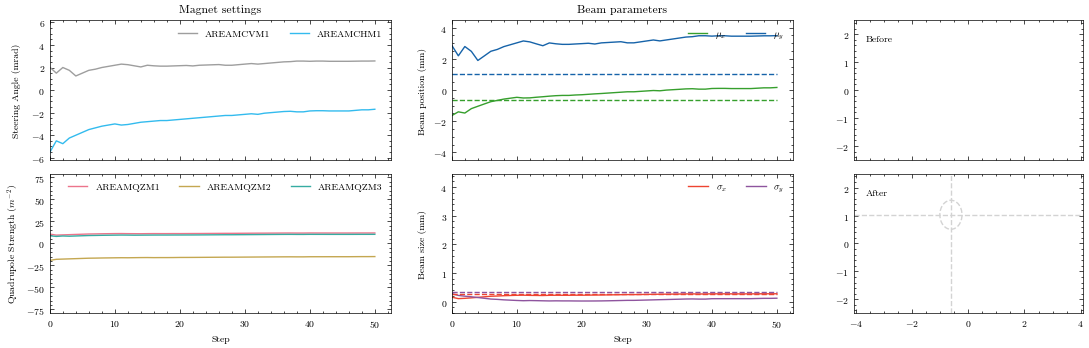

In [24]:
_ = episode.plot_summary()

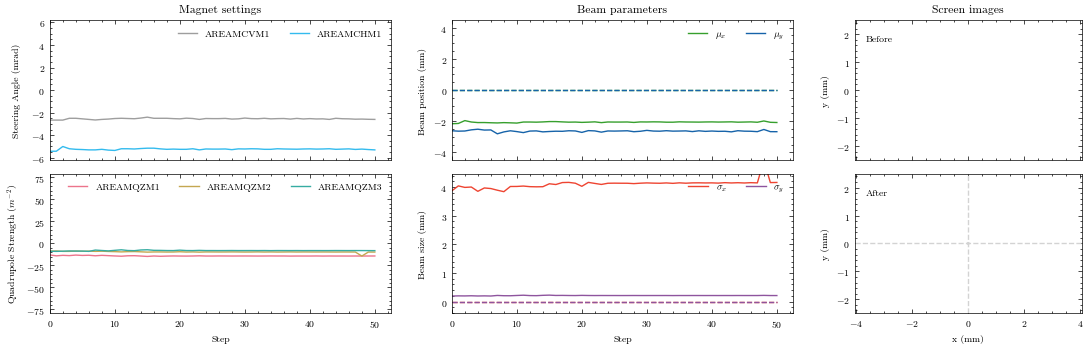

In [23]:
_ = episode.plot_summary()  # Mixtral (chain of thought)

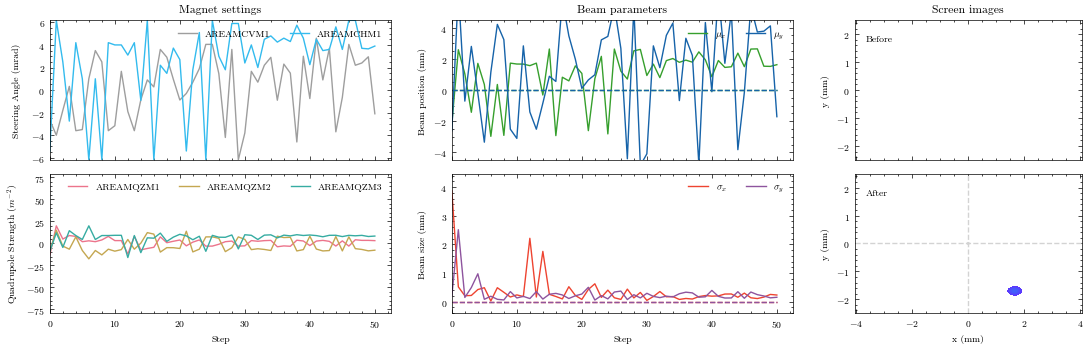

In [23]:
_ = episode.plot_summary()  # Starling (improved chain of thought)

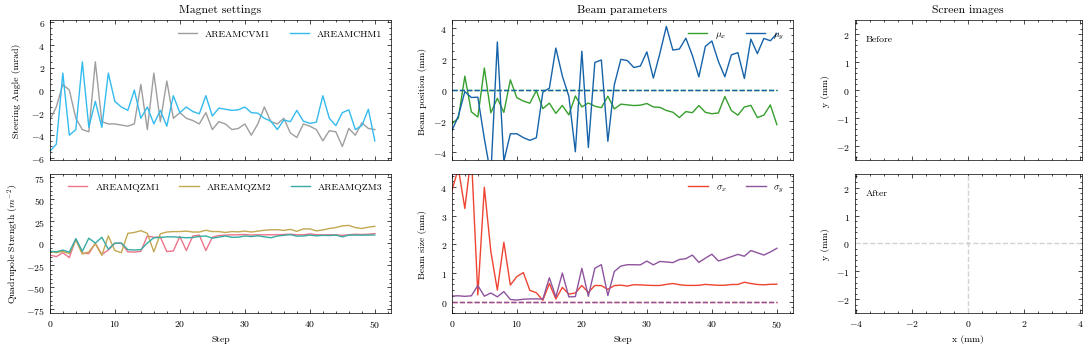

In [23]:
_ = episode.plot_summary()  # Mistral (chain of thought / improved)

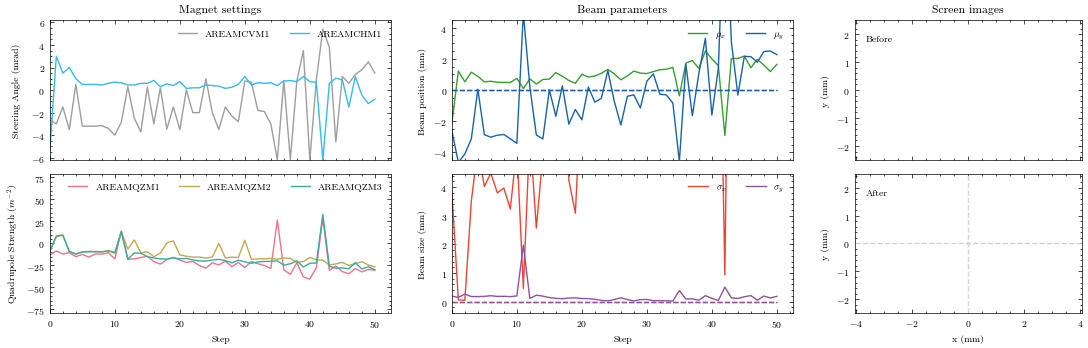

In [23]:
_ = episode.plot_summary()  # Mistral (chain of thought)

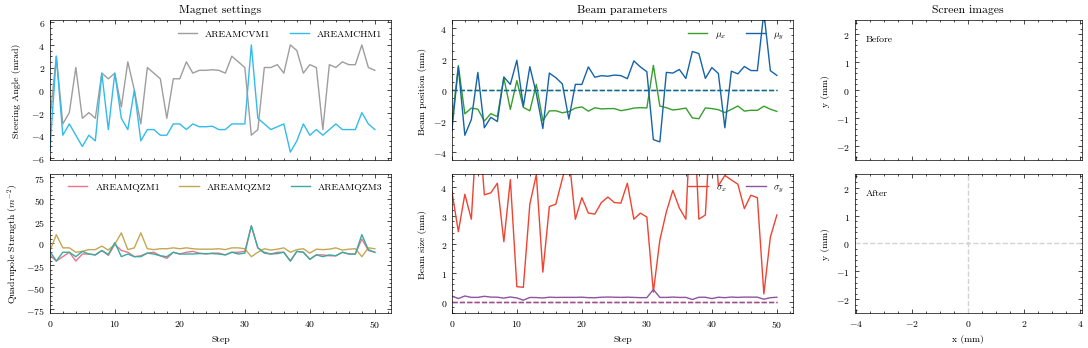

In [23]:
_ = episode.plot_summary()  # GPT 3.5 Turbo (chain of thought)

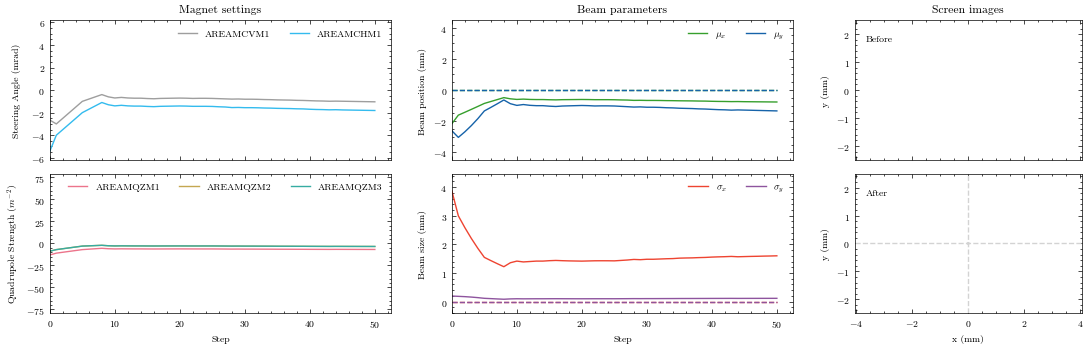

In [23]:
_ = episode.plot_summary()  # GPT 4 (chain of thought)

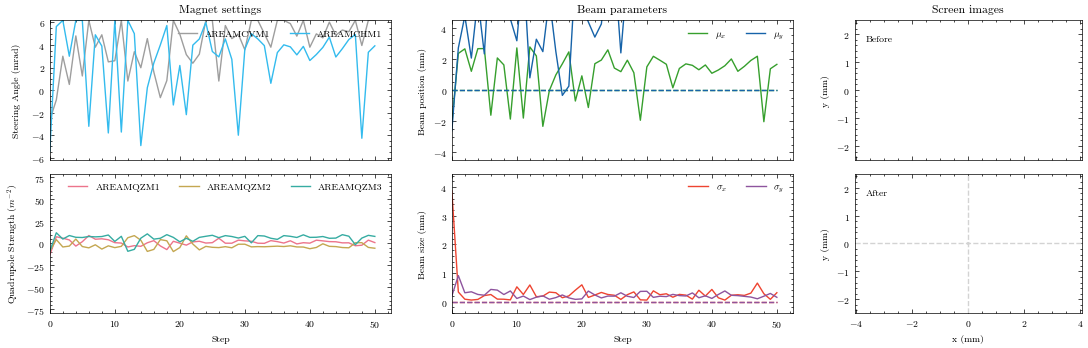

In [23]:
_ = episode.plot_summary()  # Starling 7b (chain of thought)

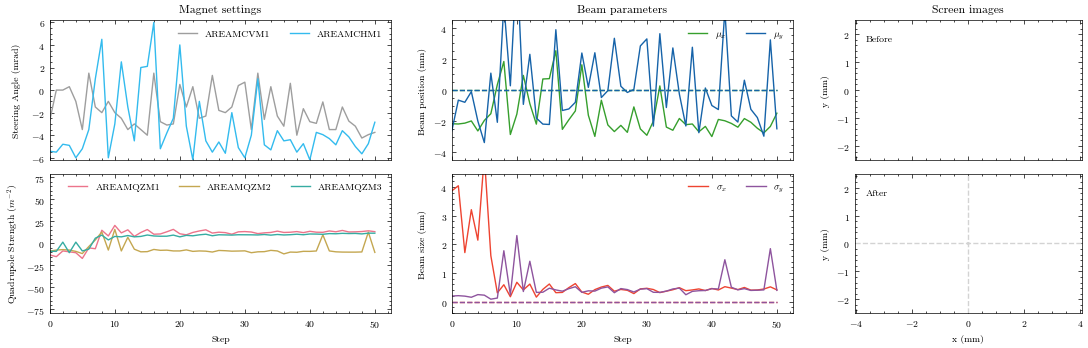

In [23]:
_ = episode.plot_summary()  # Mistral (chain of thought)

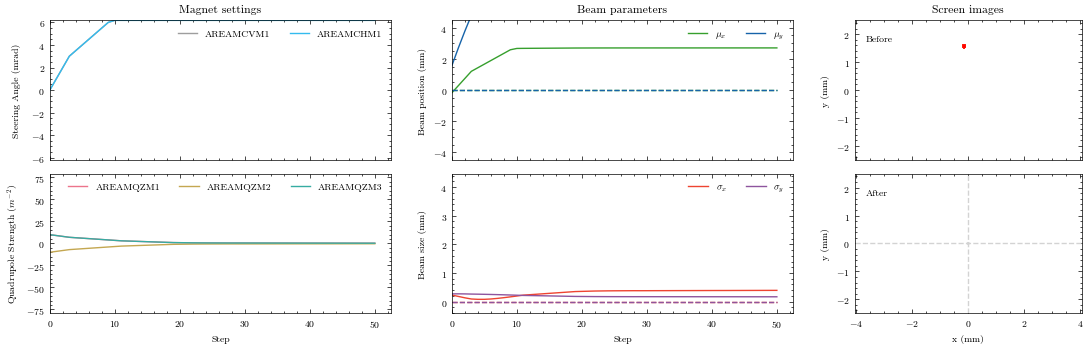

In [23]:
_ = episode.plot_summary()  # GPT-4 (Starting from FDF)

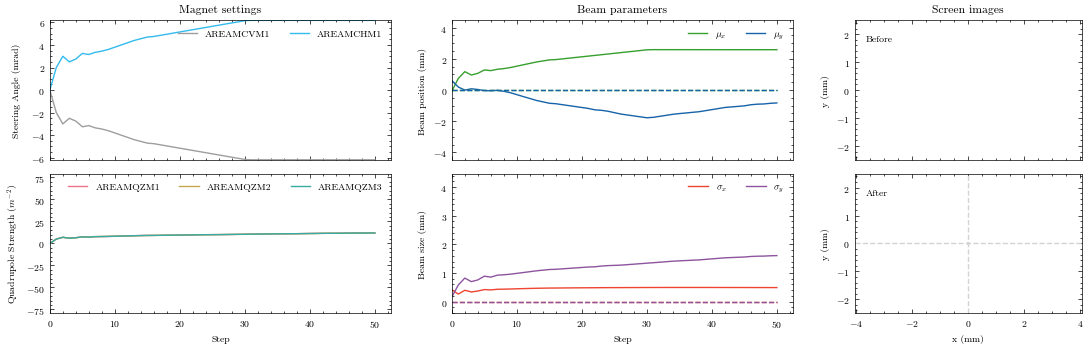

In [23]:
_ = episode.plot_summary()  # GPT-4 (Starting magnets from zero)

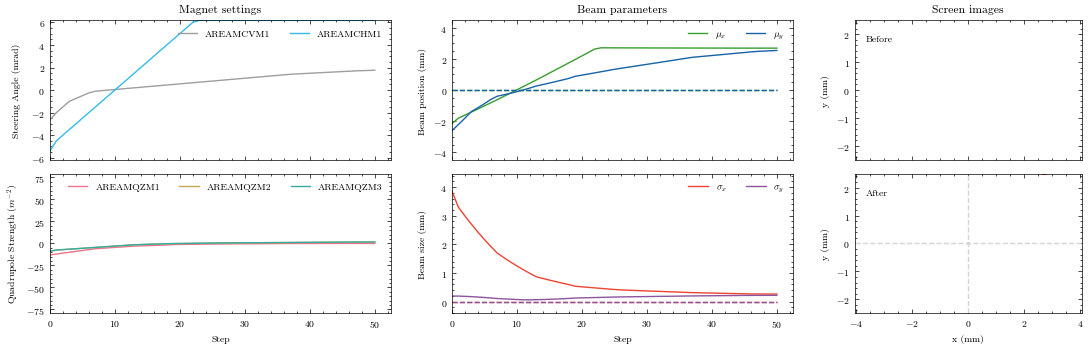

In [23]:
_ = episode.plot_summary()  # GPT-4 (do not set any magnet to zero)

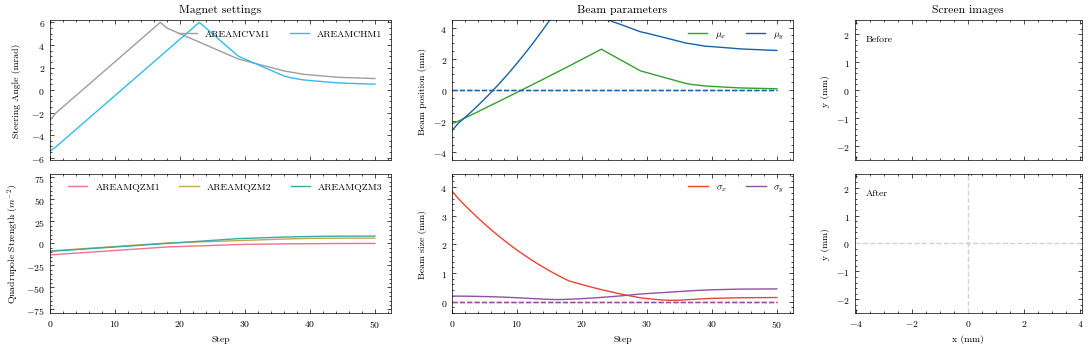

In [23]:
_ = episode.plot_summary()  # GPT-4 (do not set all magnets to zero)

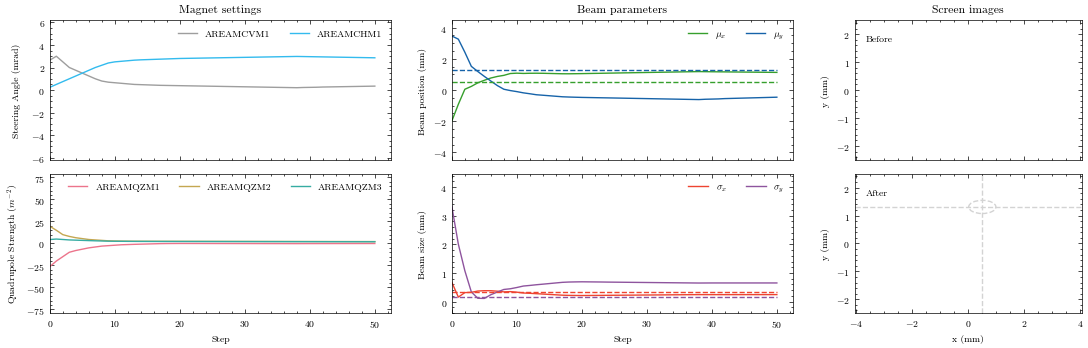

In [23]:
_ = episode.plot_summary()  # GPT-4 (Target beam different index 32)

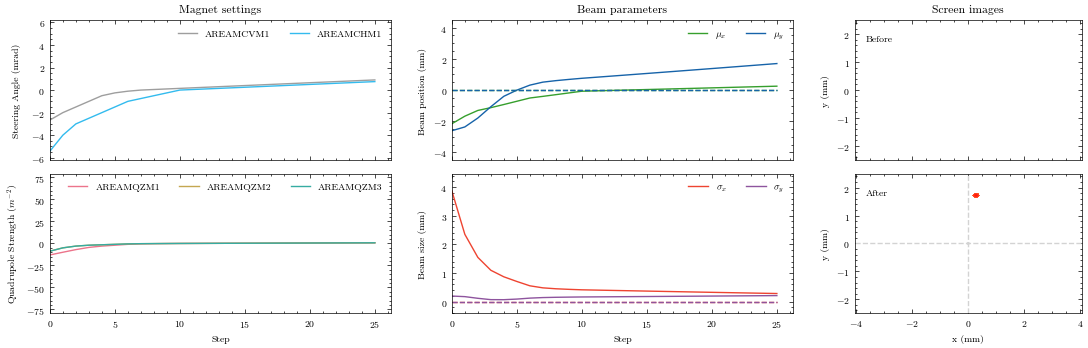

In [23]:
_ = episode.plot_summary()  # GPT-4-Turbo Preview 0125 (target in prompt + smooth)

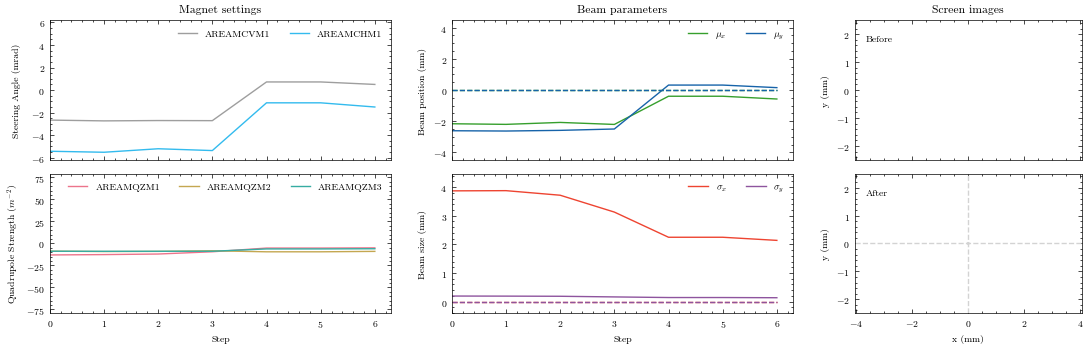

In [23]:
_ = episode.plot_summary()  # Megadolphin 120b

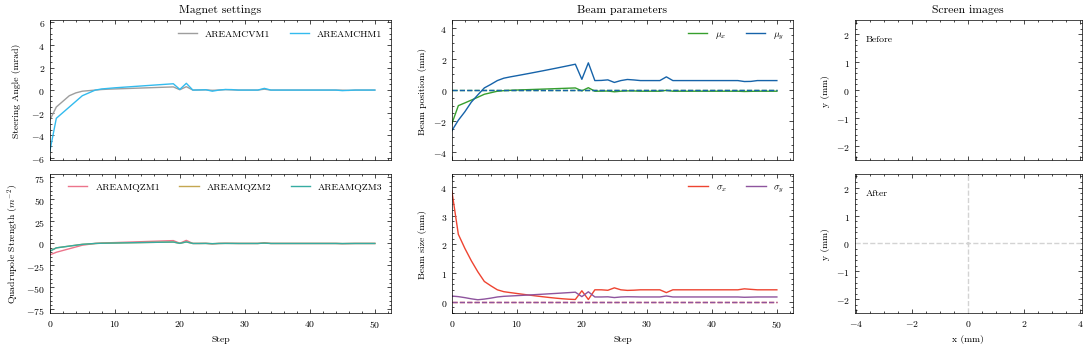

In [23]:
_ = episode.plot_summary()  # GPT-4-Turbo Preview 0125 (no units in history)

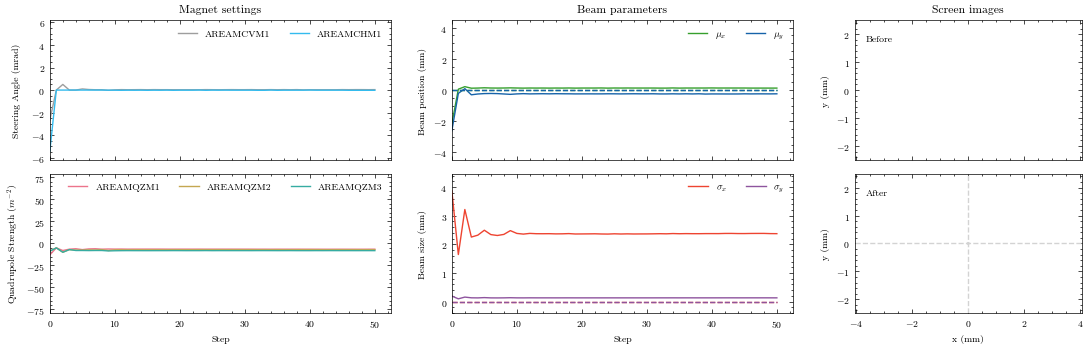

In [23]:
_ = episode.plot_summary()  # Mixtral Instruct (no units in history)

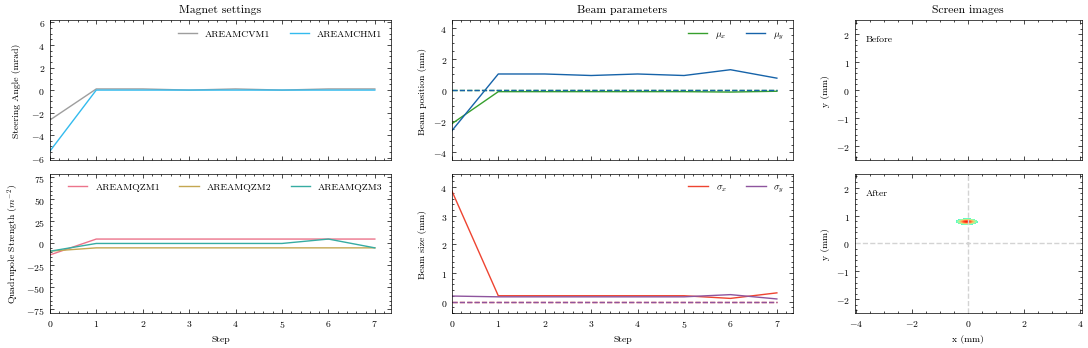

In [28]:
_ = episode.plot_summary()  # Mixtral 7x8b Instruct

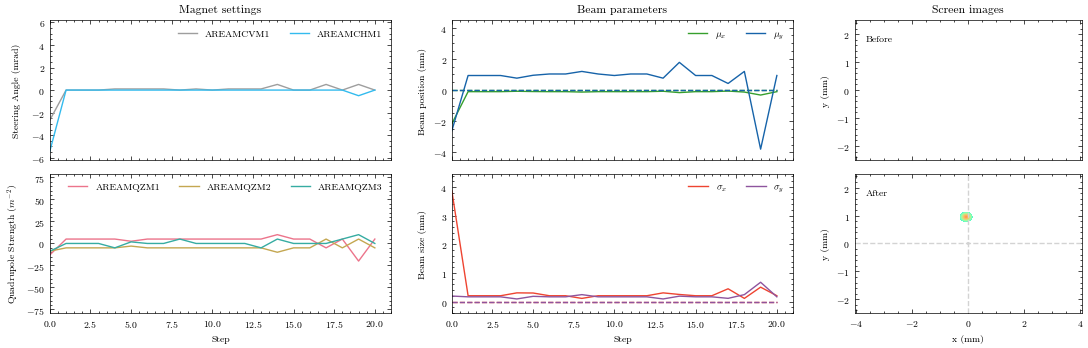

In [29]:
_ = episode.plot_summary()  # Mixtral 7x8b Instruct

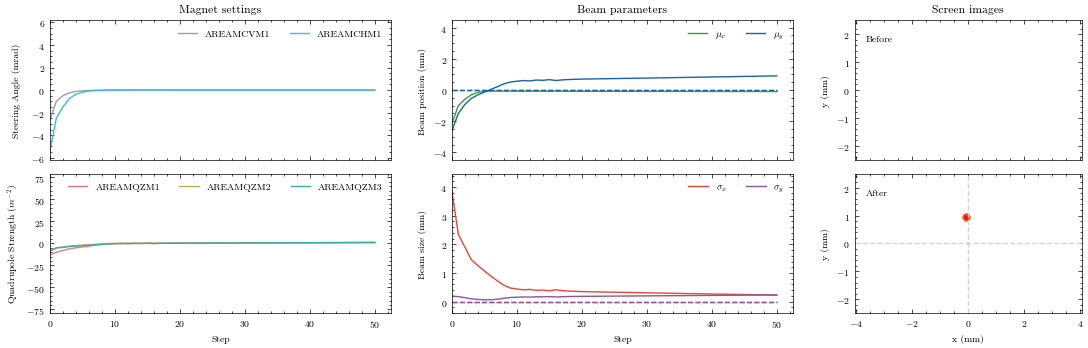

In [26]:
_ = episode.plot_summary()  # gpt-4-0125-preview

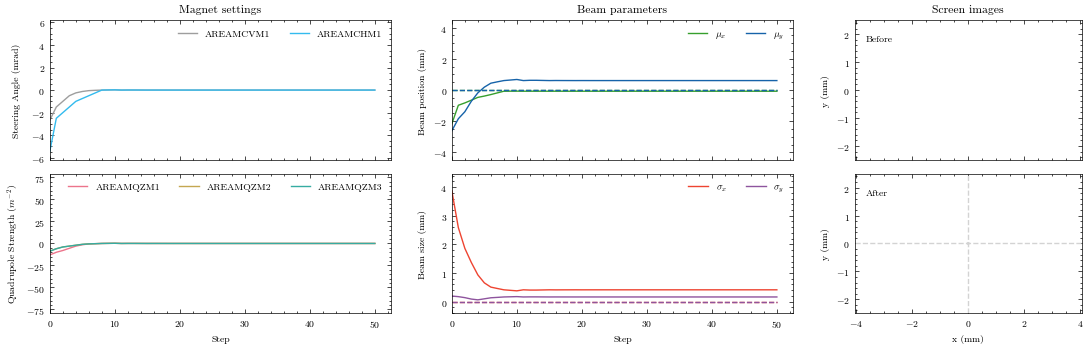

In [26]:
_ = episode.plot_summary()  # gpt-4-0125-preview

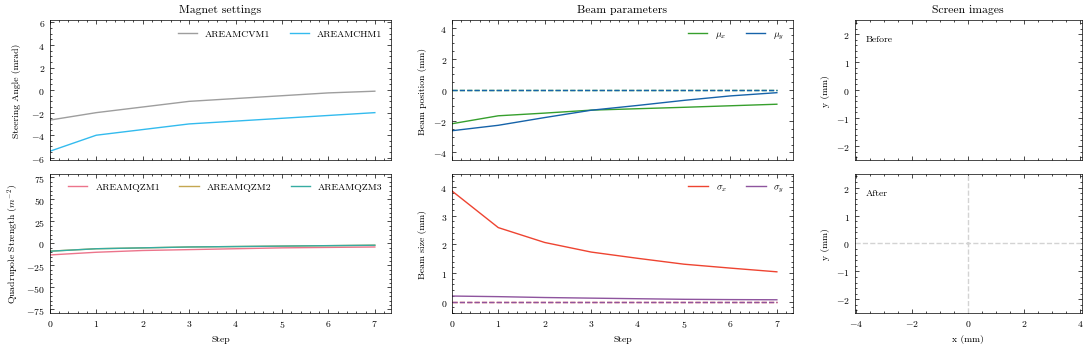

In [26]:
_ = episode.plot_summary()  # GPT-4

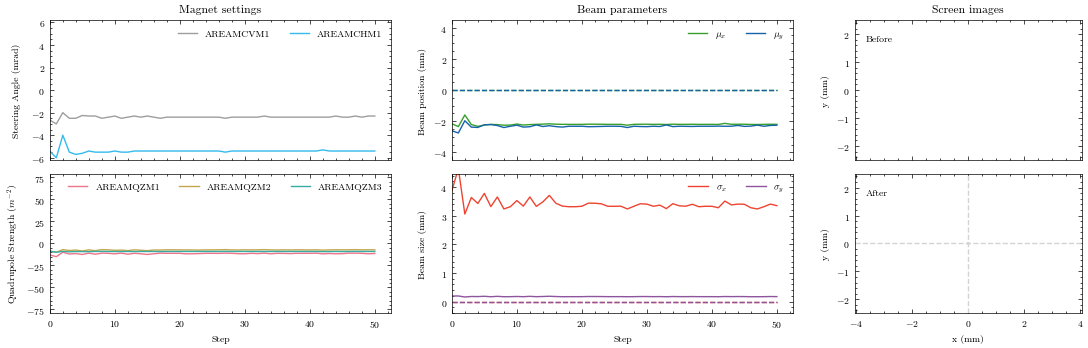

In [26]:
_ = episode.plot_summary()  # GPT-3.5-turbo-1106

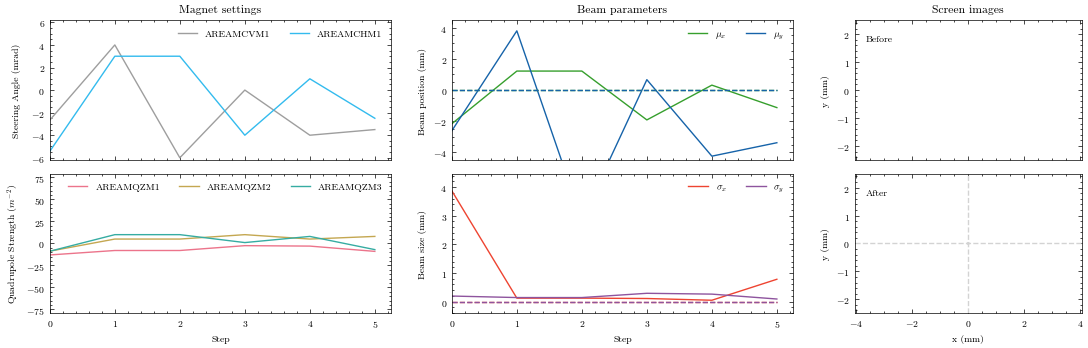

In [26]:
_ = episode.plot_summary()  # mistral-openorca

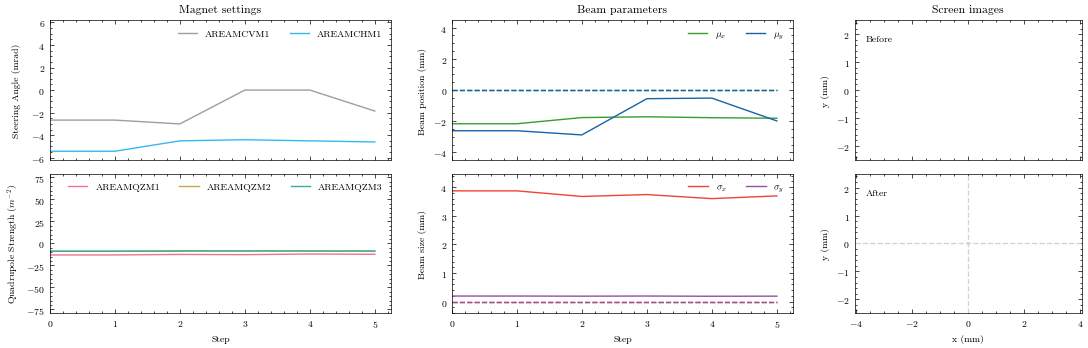

In [26]:
_ = episode.plot_summary()  # Llama2 7B-Chat

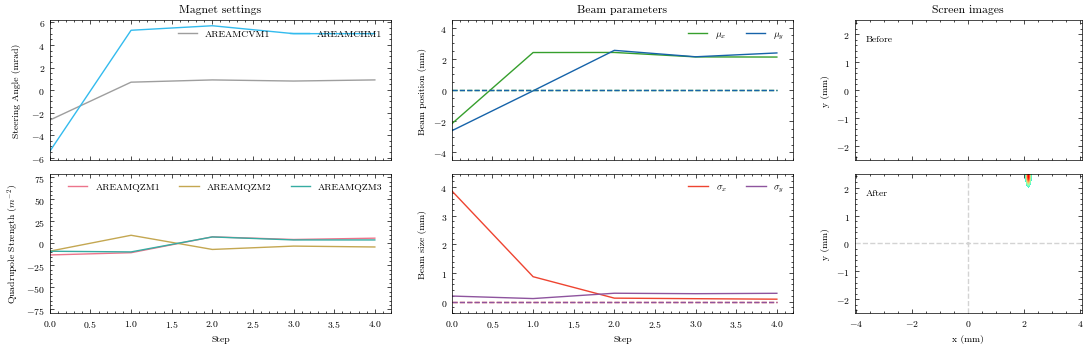

In [26]:
_ = episode.plot_summary()  # Mistral 7B Instruct

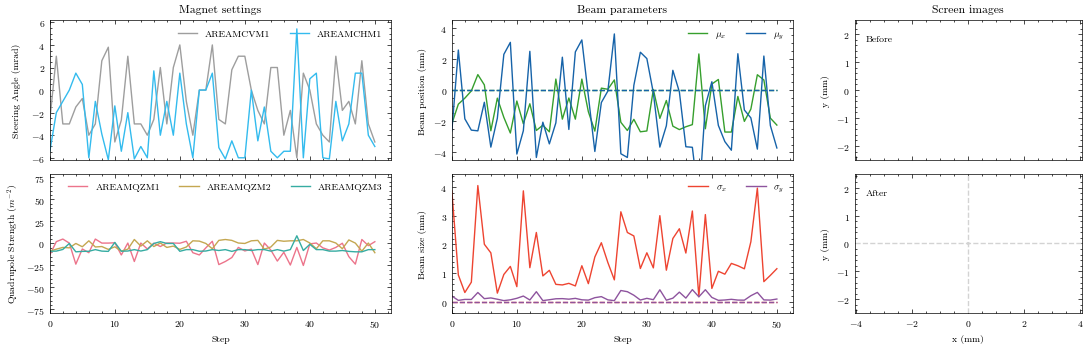

In [26]:
_ = episode.plot_summary()  # Vicuna 7B 16K

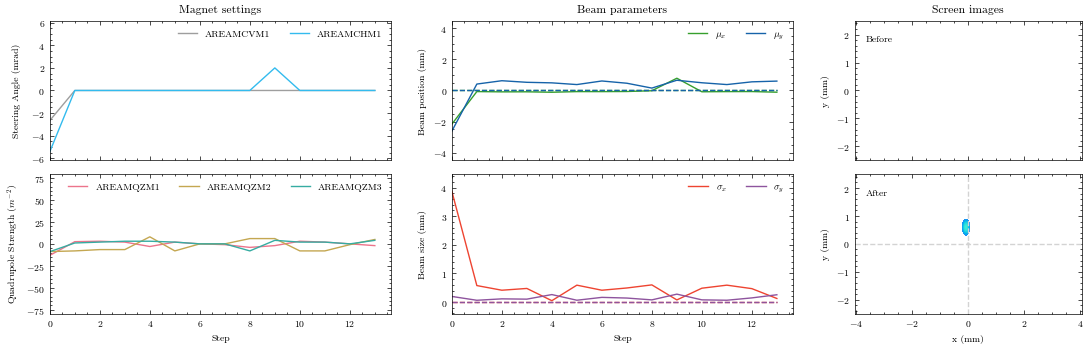

In [24]:
_ = episode.plot_summary()  # Starling

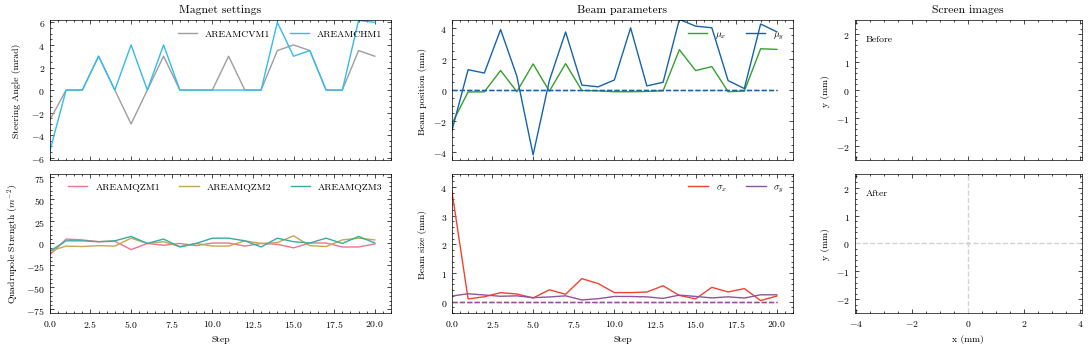

In [24]:
_ = episode.plot_summary()  # Starling

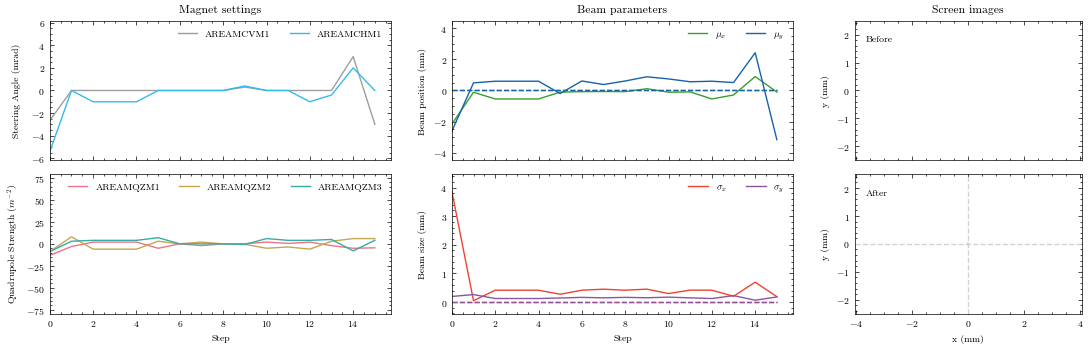

In [27]:
_ = episode.plot_summary()  # Starling

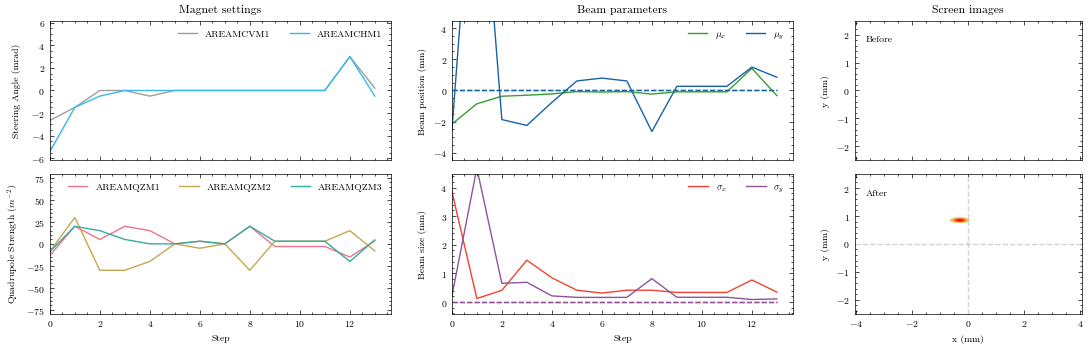

In [24]:
_ = episode.plot_summary()  # Starling

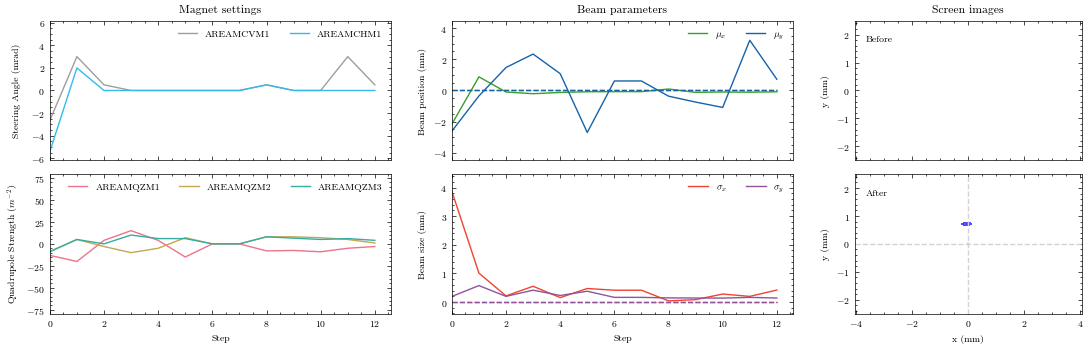

In [24]:
_ = episode.plot_summary()  # Starling

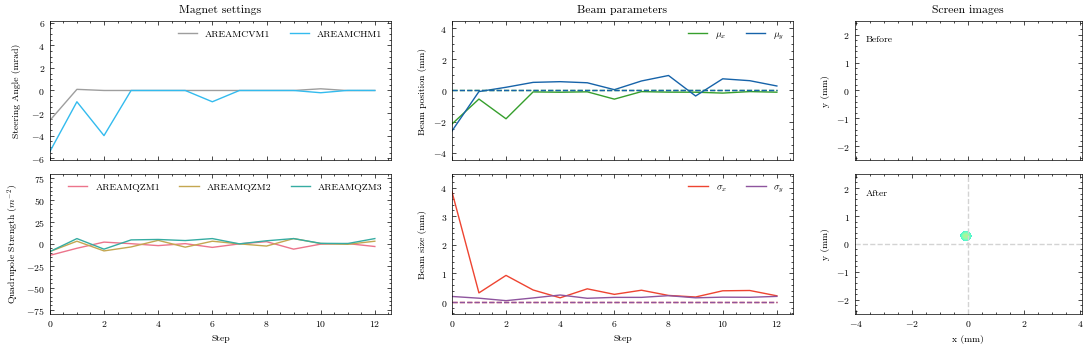

In [24]:
_ = episode.plot_summary()  # Starling

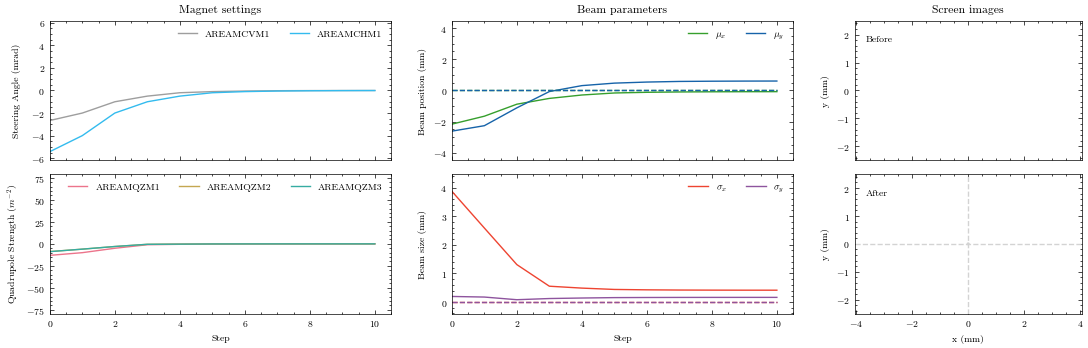

In [24]:
_ = episode.plot_summary()

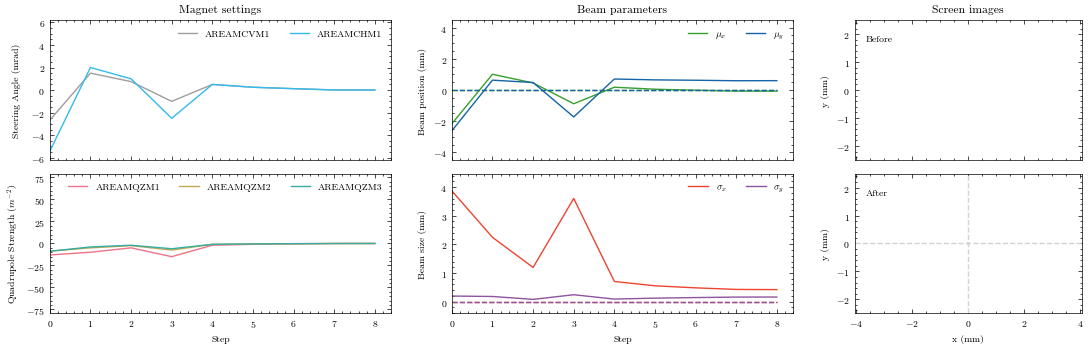

In [23]:
_ = episode.plot_summary()

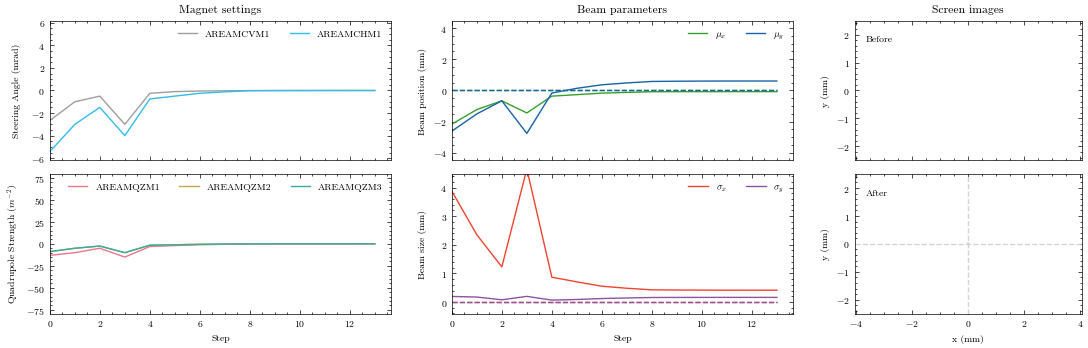

In [23]:
_ = episode.plot_summary()

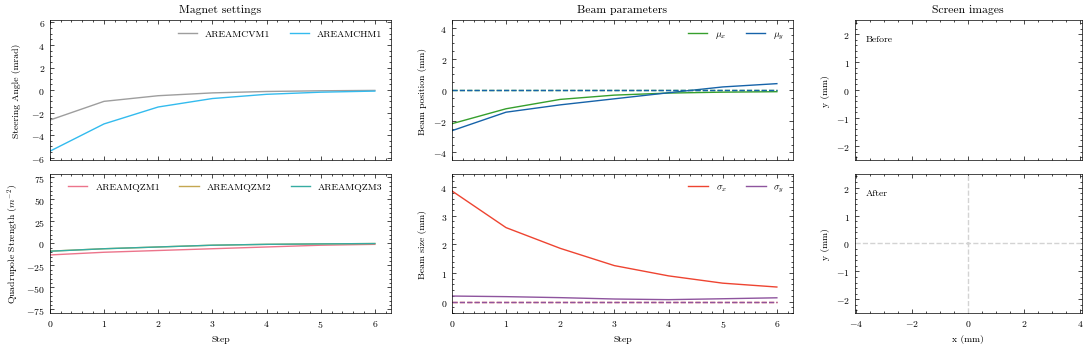

In [23]:
_ = episode.plot_summary()

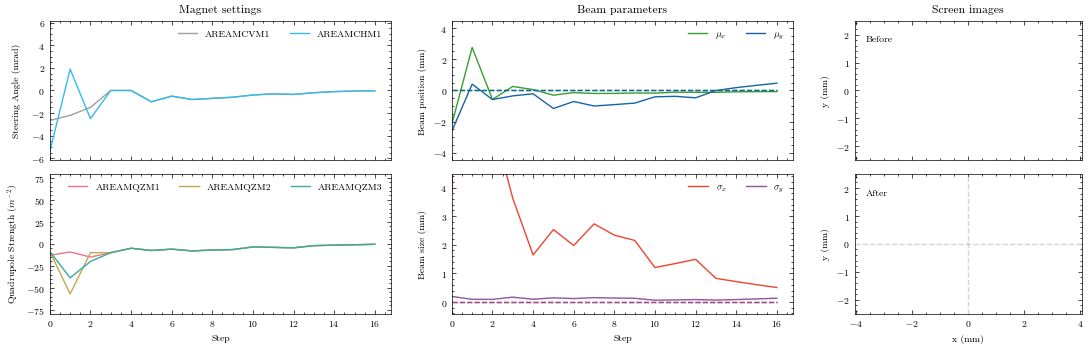

In [23]:
_ = episode.plot_summary()

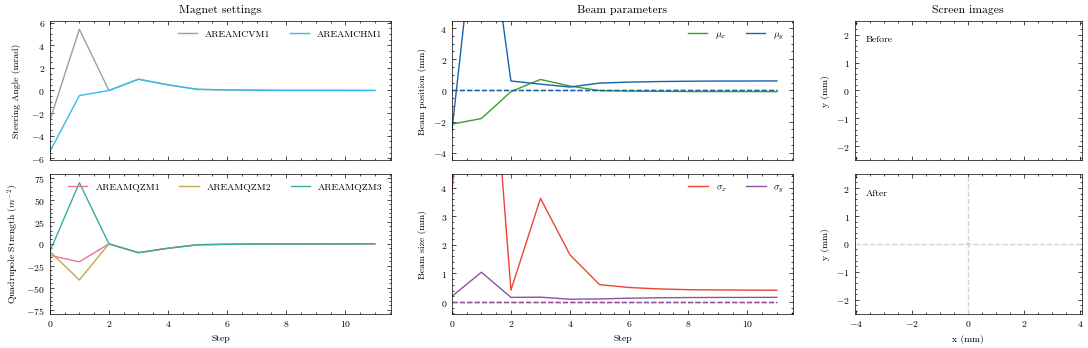

In [28]:
_ = episode.plot_summary()

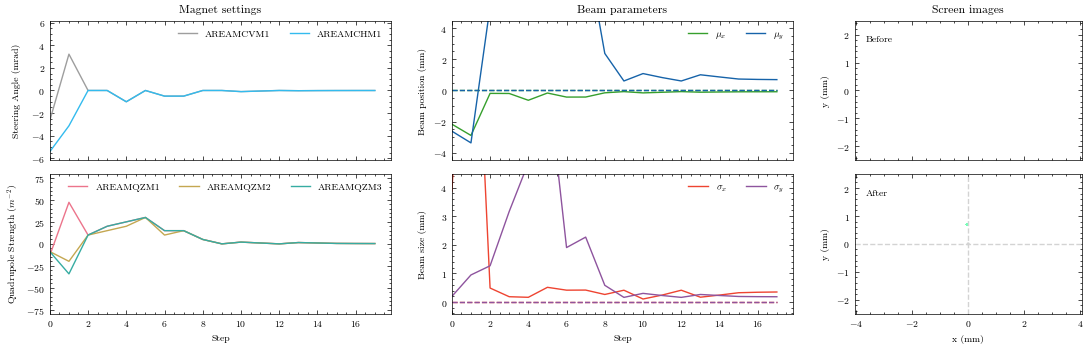

In [23]:
_ = episode.plot_summary()

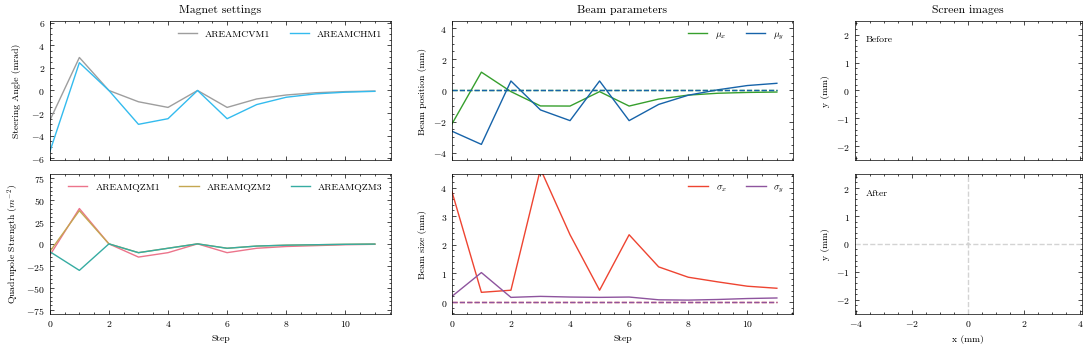

In [23]:
_ = episode.plot_summary()

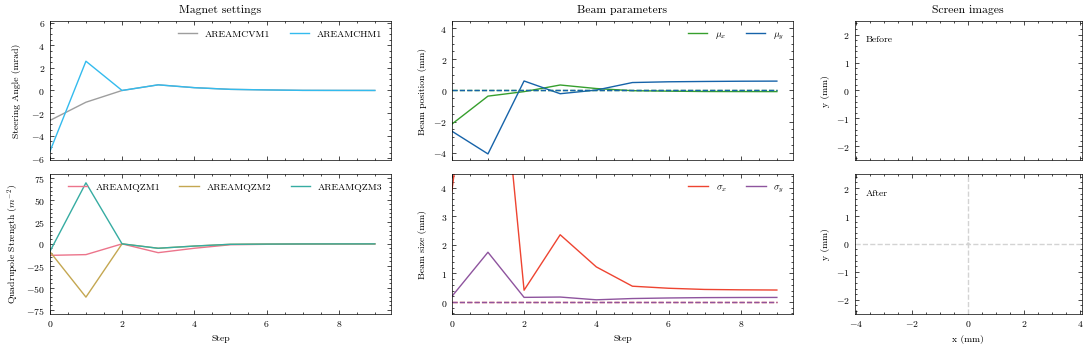

In [23]:
_ = episode.plot_summary()

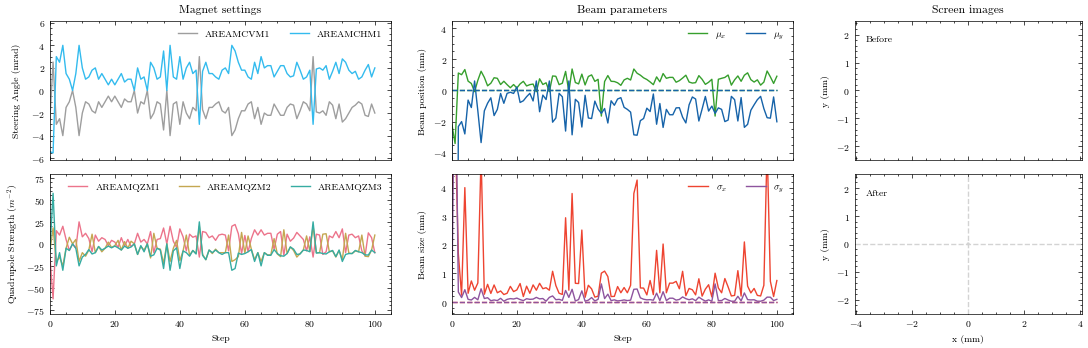

In [23]:
_ = episode.plot_summary()

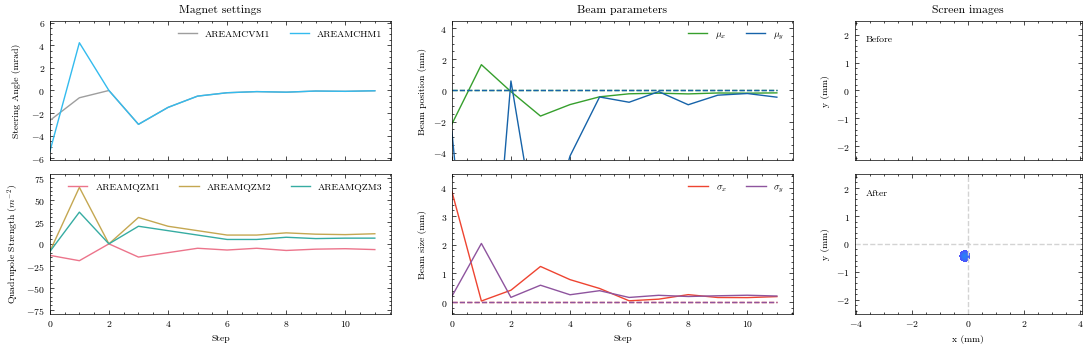

In [67]:
_ = episode.plot_summary()